In [1]:
import os

import datetime
import dateutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from ElexonDataPortal import api

# Elexon Data Portal

Examples of accessing [BMRS](https://www.bmreports.com/bmrs/) data using the third-party [Elexon Data Portal python library](https://github.com/OSUKED/ElexonDataPortal).

Important links for contextual information:
- [BMRS Reports Guide Overview](https://www.bmreports.com/bmrs/?q=help/overview)
- [BMRS Glossary](https://www.bmreports.com/bmrs/?q=help/glossary#TSDF)
- [BMRS Data Dashboard](https://www.bmreports.com/bmrs/?q=eds/main)
- [Elexon Beginners Guide](https://www.elexon.co.uk/documents/training-guidance/bsc-guidance-notes/beginners-guide-2/)
- [entsoe Manual of Procedures (MoP)](https://www.entsoe.eu/data/transparency-platform/mop/): For transparency data (i.e. those with a Bxxxx code)

## Get API key

Obtain Elexon API key from environment variable `ELEXON_API_KEY`. Ensure this is not committed to the repo.

Can also get the key from `.elexon_api_key`, if such a file is present. Must follow this route if using Jupyter within vscode/PyCharm.

In [2]:
if 'ELEXON_API_KEY' in os.environ:
    elexon_api_key = os.environ['ELEXON_API_KEY']
else:
    with open('.elexon_api_key', 'r') as f:
        elexon_api_key = f.readline()

## Create a Client

In [3]:
client = api.Client(elexon_api_key)

## Shared Functions/Variables

In [4]:
DATETIME_FORMAT = '%Y-%m-%d %H:%M'

In [5]:
def getPeriodSinceRef(timestamp, ref_date=datetime.date(2000,1,1)):
    """Determine the number of periods since the reference date.
    """
    days = (timestamp.date() - ref_date).days
    return (days * 48) + (2 * timestamp.hour) + (timestamp.minute // 30)

In [6]:
def getPeriodOfDay(timestamp):
    """Determine the number of periods since midnight.
    """
    return int((timestamp.hour*2) + (timestamp.minute/30))

## Documentation Example

The following example is given in the Elexon Data Portal documentation GitHub. Data being retrieved: Actual Generation Output per Generation Unit.

In [7]:
start_date = '2021-01-01 00:00'
end_date = '2021-01-01 00:30'

In [8]:
df_B1610 = client.get_B1610(start_date, end_date)

B1610: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


In [9]:
df_B1610.head(3)

,local_datetime,documentType,businessType,processType,timeSeriesID,curveType,settlementDate,powerSystemResourceType,registeredResourceEICCode,marketGenerationUnitEICCode,...,bMUnitID,nGCBMUnitID,activeFlag,documentID,documentRevNum,resolution,start,end,settlementPeriod,quantity
0,2021-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-385,Sequential fixed size block,2021-01-01,Generation,48W000000SHBA-2A,48W000000SHBA-2A,...,T_SHBA-2,SHBA-2,Y,ELX-EMFIP-AGOG-25548596,1,PT30M,2021-01-01,2021-01-01,1,541.6
1,2021-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-186,Sequential fixed size block,2021-01-01,Generation,48W00000CLDRW-16,48W00000CLDRW-16,...,E_CLDRW-1,CLDRW-1,Y,ELX-EMFIP-AGOG-25548596,1,PT30M,2021-01-01,2021-01-01,1,16.65
2,2021-01-01 00:00:00+00:00,Actual generation,Production,Realised,ELX-EMFIP-AGOG-TS-336,Sequential fixed size block,2021-01-01,Generation,48W00000HOWAO-1M,48W00000HOWAO-1M,...,T_HOWAO-1,HOWAO-1,Y,ELX-EMFIP-AGOG-25548596,1,PT30M,2021-01-01,2021-01-01,1,46.628


## FUELHH

Extracting [Generation by Fuel Type](https://www.bmreports.com/bmrs/?q=generation/fueltype/current). This is what Elexon use on their own data dashboard - see links at top of notebook.

### Set date range

In [10]:
start_date = '2021-12-01 00:00'
end_date = '2021-12-06 23:30'

start_date_str = start_date[:10].replace('-','')
end_date_str = end_date[:10].replace('-','')

### Request/Load data

In [11]:
FUELHH_filename = f'FUELHH_{start_date_str}_{end_date_str}.csv'
FUELHH_filename

'FUELHH_20211201_20211206.csv'

In [12]:
if os.path.isfile(os.path.join('data', FUELHH_filename)):
    df_FUELHH = pd.read_csv(os.path.join('data', FUELHH_filename), index_col=0, parse_dates=True)
else:
    if not os.path.isdir('data'):
        os.mkdir('data')

    start_date_obj = datetime.datetime.strptime(start_date, DATETIME_FORMAT)
    end_date_obj = datetime.datetime.strptime(end_date, DATETIME_FORMAT)

    thirty_min_delta = dateutil.relativedelta.relativedelta(minutes=+30)
    month_delta = dateutil.relativedelta.relativedelta(months=+1)

    get_month_end = lambda x: x + month_delta - thirty_min_delta

    if end_date_obj <= get_month_end(start_date_obj):
        df_FUELHH = client.get_FUELHH(start_date, end_date)
    else:
        print(f'{start_date_obj} to {get_month_end(start_date_obj)}')
        df_FUELHH = client.get_FUELHH(
            start_date,
            datetime.datetime.strftime(get_month_end(start_date_obj), DATETIME_FORMAT)
            )

        cur_time_obj = start_date_obj + month_delta
        while cur_time_obj < datetime.datetime.strptime(end_date, DATETIME_FORMAT) - month_delta:
            print(f'{cur_time_obj} to {get_month_end(cur_time_obj)}')
            df_FUELHH_tmp = client.get_FUELHH(
                datetime.datetime.strftime(cur_time_obj, DATETIME_FORMAT),
                datetime.datetime.strftime(get_month_end(cur_time_obj), DATETIME_FORMAT))
            df_FUELHH = pd.concat((df_FUELHH, df_FUELHH_tmp))
            cur_time_obj += month_delta
        print(f'{cur_time_obj} to {end_date_obj}')
        df_FUELHH_tmp = client.get_FUELHH(
            datetime.datetime.strftime(cur_time_obj, DATETIME_FORMAT),
            end_date)
        df_FUELHH = pd.concat((df_FUELHH, df_FUELHH_tmp))

    df_FUELHH.to_csv(os.path.join('data', FUELHH_filename))

In [13]:
df_FUELHH.head()

,local_datetime,recordType,startTimeOfHalfHrPeriod,settlementPeriod,ccgt,oil,coal,nuclear,wind,ps,...,intfr,intirl,intned,intew,biomass,intnem,intelec,intifa2,intnsl,activeFlag
0,2021-12-01 00:00:00+00:00,FUELHH,2021-12-01,1,2470,0,0,5102,11912,0,...,0,272,1048,504,2340,1000,0,0,0,Y
1,2021-12-01 00:30:00+00:00,FUELHH,2021-12-01,2,2436,0,0,5098,12345,0,...,0,272,1048,504,2362,1000,0,0,0,Y
2,2021-12-01 01:00:00+00:00,FUELHH,2021-12-01,3,2343,0,0,5102,12665,0,...,0,272,1048,504,2328,988,0,0,0,Y
3,2021-12-01 01:30:00+00:00,FUELHH,2021-12-01,4,2303,0,0,5101,12654,0,...,0,272,1048,504,2284,974,0,0,0,Y
4,2021-12-01 02:00:00+00:00,FUELHH,2021-12-01,5,2392,0,0,5100,12810,0,...,0,272,648,504,2411,418,0,0,0,Y


### Necessary Processing

In [14]:
FUELHH_num_cols =  ['ccgt', 'oil', 'coal', 'nuclear', 'wind', 'ps', 'npshyd', 'ocgt', 'other', 'intfr', 'intirl', 'intned', 'intew', 'biomass', 'intnem', 'intelec', 'intifa2', 'intnsl']
FUELHH_inter_cols = ['intfr', 'intirl', 'intned', 'intew', 'intnem', 'intelec', 'intifa2', 'intnsl']

def process_fuelhh_data(df):
    df = df.copy()

    df[FUELHH_num_cols] = df[FUELHH_num_cols].astype(int)
    df['total'] = df[FUELHH_num_cols].sum(axis=1)
    df['int'] = df[FUELHH_inter_cols].sum(axis=1)

    df["local_datetime"] = pd.to_datetime(df["local_datetime"])
    df["startTimeOfHalfHrPeriod"] = pd.to_datetime(df["startTimeOfHalfHrPeriod"])
    df.set_index("local_datetime", inplace=True)

    df['periodSinceRef'] = df.index.to_series().apply(getPeriodSinceRef)
    df['periodOfDay'] = df.index.to_series().apply(getPeriodOfDay)

    return df

In [15]:
df_FUELHH = process_fuelhh_data(df_FUELHH)

In [16]:
df_FUELHH.head()

,recordType,startTimeOfHalfHrPeriod,settlementPeriod,ccgt,oil,coal,nuclear,wind,ps,npshyd,...,biomass,intnem,intelec,intifa2,intnsl,activeFlag,total,int,periodSinceRef,periodOfDay
local_datetime,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:00:00+00:00,FUELHH,2021-12-01,1,2470,0,0,5102,11912,0,531,...,2340,1000,0,0,0,Y,25260,2824,384240,0
2021-12-01 00:30:00+00:00,FUELHH,2021-12-01,2,2436,0,0,5098,12345,0,536,...,2362,1000,0,0,0,Y,25686,2824,384241,1
2021-12-01 01:00:00+00:00,FUELHH,2021-12-01,3,2343,0,0,5102,12665,0,538,...,2328,988,0,0,0,Y,25887,2812,384242,2
2021-12-01 01:30:00+00:00,FUELHH,2021-12-01,4,2303,0,0,5101,12654,0,541,...,2284,974,0,0,0,Y,25780,2798,384243,3
2021-12-01 02:00:00+00:00,FUELHH,2021-12-01,5,2392,0,0,5100,12810,0,551,...,2411,418,0,0,0,Y,25200,1842,384244,4


In [17]:
FUELHH_supply_types = ['ccgt', 'oil', 'coal', 'nuclear', 'wind', 'ps', 'npshyd', 'ocgt', 'other', 'biomass', 'int']

### Visualisation

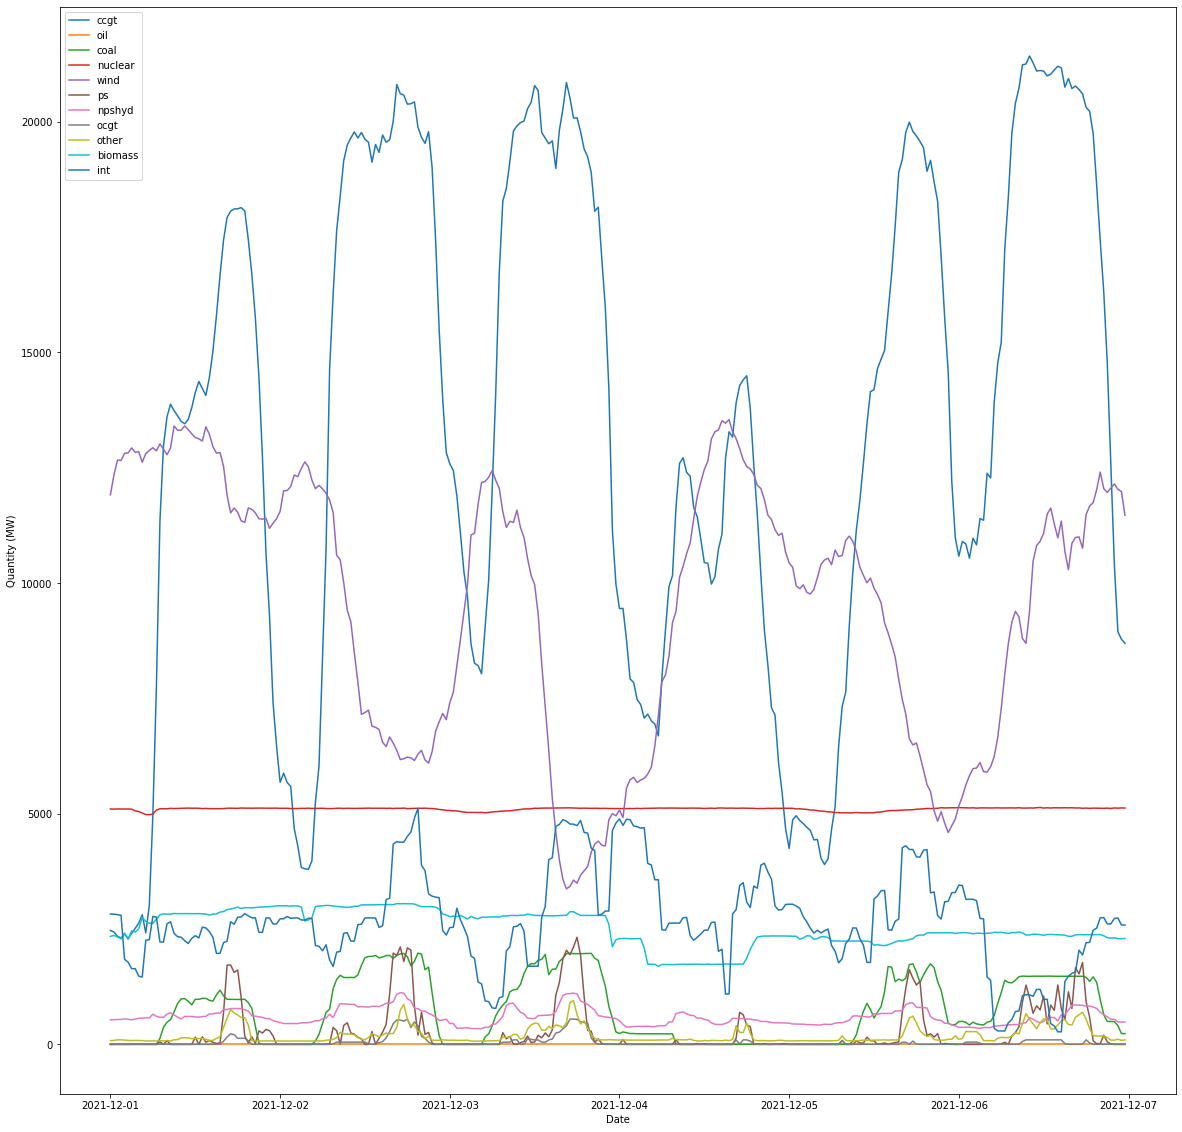

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))

FUELHH_plot_cols = ['ccgt', 'oil', 'coal', 'nuclear', 'wind', 'ps', 'npshyd', 'ocgt', 'other', 'biomass', 'int']

ax.plot(df_FUELHH[FUELHH_plot_cols], label=FUELHH_plot_cols)

ax.set_xlabel('Date')
ax.set_ylabel('Quantity (MW)')
ax.legend()
fig.savefig('elexon_fuel_hh.jpeg', pad_inches=0.2, bbox_inches='tight')

## Actual Aggregated Generation perType - B1620

Extracting [Actual Aggregated Generation perType](https://www.bmreports.com/bmrs/?q=actgenration/actualaggregated).

### Set date range

In [19]:
# start_date = '2020-01-01 00:00'
# end_date = '2020-12-31 23:30'

start_date = '2021-12-01 00:00'
end_date = '2021-12-07 00:00'

start_date_str = start_date[:10].replace('-','')
end_date_str = end_date[:10].replace('-','')

### Request/Load data

In [20]:
b1620_filename = f'B1620_{start_date_str}_{end_date_str}.csv'
b1620_filename

'B1620_20211201_20211207.csv'

In [21]:
if os.path.isfile(os.path.join('data', b1620_filename)):
    df_B1620 = pd.read_csv(os.path.join('data', b1620_filename), index_col=0, parse_dates=True)
else:
    if not os.path.isdir('data'):
        os.mkdir('data')

    df_B1620 = client.get_B1620(start_date, end_date)
    df_B1620.to_csv(os.path.join('data', b1620_filename))

In [22]:
df_B1620.head()

,local_datetime,documentType,businessType,processType,timeSeriesID,quantity,curveType,resolution,settlementDate,settlementPeriod,powerSystemResourceType,activeFlag,documentID,documentRevNum
0,2021-12-01 00:00:00+00:00,Actual generation per type,Solar generation,Realised,NGET-EMFIP-AGPT-TS-21887936,0.000,Sequential fixed size block,PT30M,2021-12-01,1,"""Solar""",Y,NGET-EMFIP-AGPT-06397371,1
1,2021-12-01 00:00:00+00:00,Actual generation per type,Wind generation,Realised,NGET-EMFIP-AGPT-TS-21887937,5707.919,Sequential fixed size block,PT30M,2021-12-01,1,"""Wind Offshore""",Y,NGET-EMFIP-AGPT-06397371,1
2,2021-12-01 00:00:00+00:00,Actual generation per type,Wind generation,Realised,NGET-EMFIP-AGPT-TS-21887938,6347.736,Sequential fixed size block,PT30M,2021-12-01,1,"""Wind Onshore""",Y,NGET-EMFIP-AGPT-06397371,1
3,2021-12-01 00:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887939,81.000,Sequential fixed size block,PT30M,2021-12-01,1,"""Other""",Y,NGET-EMFIP-AGPT-06397371,1
4,2021-12-01 00:00:00+00:00,Actual generation per type,Production,Realised,NGET-EMFIP-AGPT-TS-21887940,5102.000,Sequential fixed size block,PT30M,2021-12-01,1,"""Nuclear""",Y,NGET-EMFIP-AGPT-06397371,1


### Necessary Processing

In [23]:
def process_supply_data(df):
    df = df.copy()

    df["powerSystemResourceType"] = df["powerSystemResourceType"].replace(
        to_replace=r'"', value='', regex=True
    )

    df["quantity"] = df["quantity"].astype(float)

    df["documentRevNum"] = df["documentRevNum"].astype(int)
    df = df.loc[df_B1620['documentRevNum'] == 1]

    df["local_datetime"] = pd.to_datetime(df["local_datetime"])
    df.set_index("local_datetime", inplace=True)

    df['periodSinceRef'] = df.index.to_series().apply(getPeriodSinceRef)
    df['periodOfDay'] = df.index.to_series().apply(getPeriodOfDay)
    
    return df

In [24]:
df_B1620 = process_supply_data(df_B1620)

TODO: Implement check which ensures that no other values are found in these columns.

In [25]:
df_B1620[["documentType", "businessType", "processType", "curveType", "resolution", "activeFlag", "documentRevNum"]].drop_duplicates()

,documentType,businessType,processType,curveType,resolution,activeFlag,documentRevNum
local_datetime,,,,,,,
2021-12-01 00:00:00+00:00,Actual generation per type,Solar generation,Realised,Sequential fixed size block,PT30M,Y,1
2021-12-01 00:00:00+00:00,Actual generation per type,Wind generation,Realised,Sequential fixed size block,PT30M,Y,1
2021-12-01 00:00:00+00:00,Actual generation per type,Production,Realised,Sequential fixed size block,PT30M,Y,1


### Data Investigation

In [26]:
df_B1620.columns

Index(['documentType', 'businessType', 'processType', 'timeSeriesID',
       'quantity', 'curveType', 'resolution', 'settlementDate',
       'settlementPeriod', 'powerSystemResourceType', 'activeFlag',
       'documentID', 'documentRevNum', 'periodSinceRef', 'periodOfDay'],
      dtype='object')

In [27]:
supply_types = df_B1620["powerSystemResourceType"].unique()
supply_types

array(['Solar', 'Wind Offshore', 'Wind Onshore', 'Other', 'Nuclear',
       'Fossil Oil', 'Fossil Gas', 'Fossil Hard coal',
       'Hydro Run-of-river and poundage', 'Hydro Pumped Storage',
       'Biomass'], dtype=object)

### Visualisation

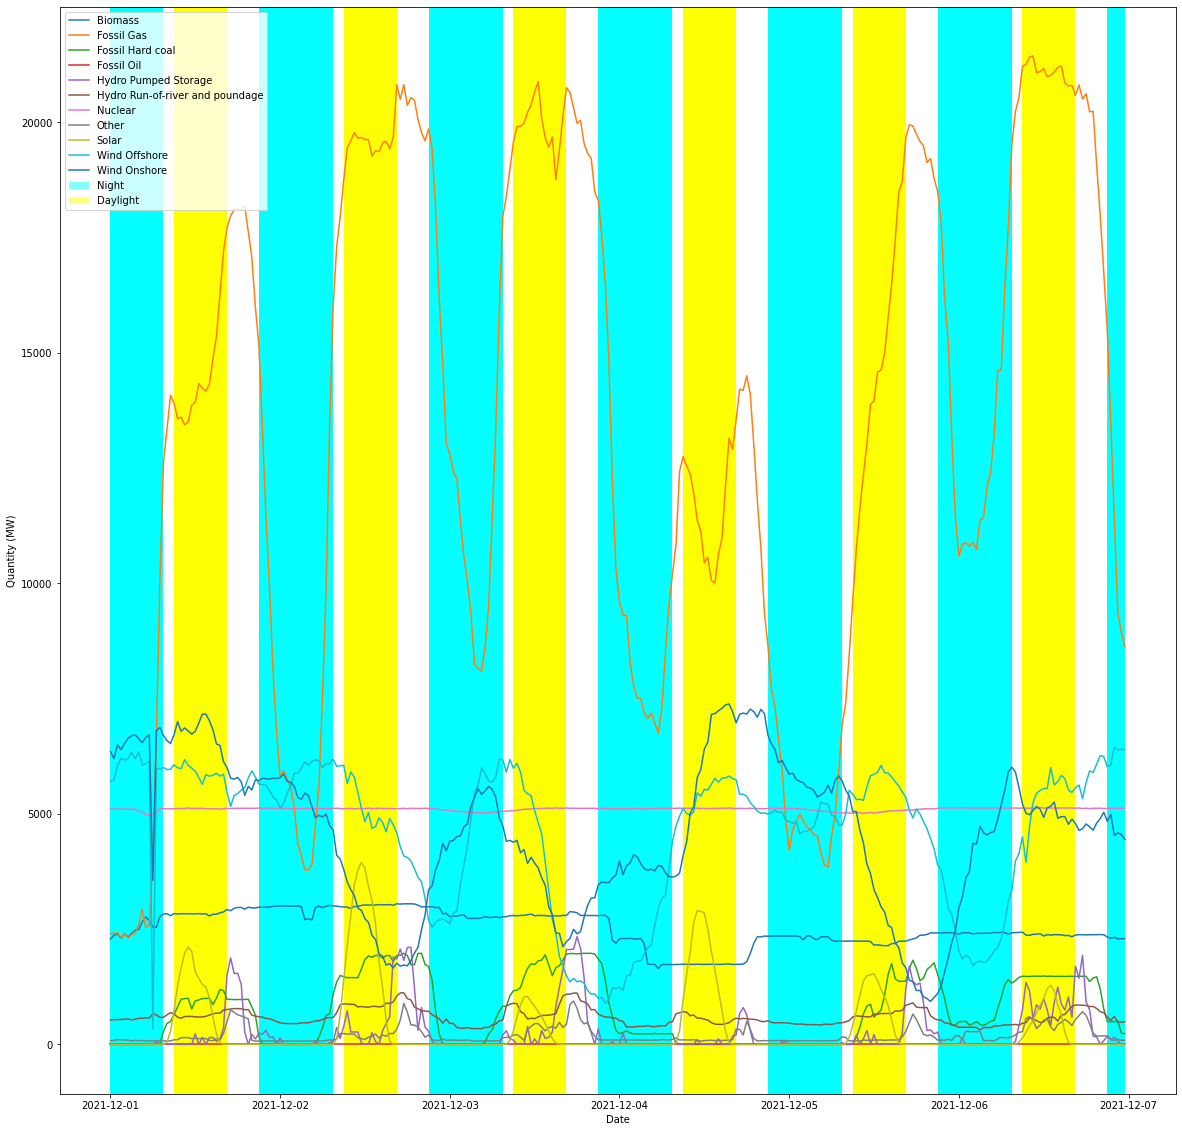

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(20,20))
legend_labels = []

for gen_type, gen_df in df_B1620.groupby("powerSystemResourceType"):
    # gen_df = df_B1620.loc[df_B1620["powerSystemResourceType"] == gen_type, 'quantity']
    ax.plot(
        gen_df['quantity'],
        ls='-',
    )
    legend_labels.append(gen_type)

sunrise = 9
sunset = 16

core_day_start_hr = 7
core_day_end_hr = 21

for d in np.unique(df_B1620.index.date):
    core_day_start = datetime.datetime(d.year, d.month, d.day, core_day_start_hr)
    core_day_end = datetime.datetime(d.year, d.month, d.day, core_day_end_hr)

    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    
    core_day_mask = (gen_df.index.hour >= core_day_end_hr) | (gen_df.index.hour <= core_day_start_hr)
    ax.fill_between(
        gen_df.index, 0, 1, where=core_day_mask, facecolor='cyan', alpha=0.5, transform=trans,
    )
    
    sunshine_mask = (gen_df.index.hour >= sunrise) & (gen_df.index.hour <= sunset)
    ax.fill_between(
        gen_df.index, 0, 1, where=sunshine_mask, facecolor='yellow', alpha=0.5, transform=trans,
    )

legend_labels.extend(['Night', 'Daylight'])
ax.set_xlabel('Date')
ax.set_ylabel('Quantity (MW)')
ax.legend(legend_labels)
fig.savefig('elexon_power_generation.jpeg', pad_inches=0.2, bbox_inches='tight')

Create mapping between the generation types in FUELHH and B1620.

In [29]:
supply_type_lookup = {
    # '': 'Solar',
    # '': 'Wind Offshore',
    'wind': 'Wind Combined',
    'other': 'Other',
    'nuclear': 'Nuclear',
    'oil': 'Fossil Oil',
    'ccgt': 'Fossil Gas',
    'coal': 'Fossil Hard coal',
    'npshyd': 'Hydro Run-of-river and poundage',
    'ps': 'Hydro Pumped Storage',
    'biomass': 'Biomass',
    'int': 'Interconnector'
}

Plot FUELHH and B1620 generation data - hope is that these will be very similar, given (in theory) they should be the same data. Still need to identify technical differences.

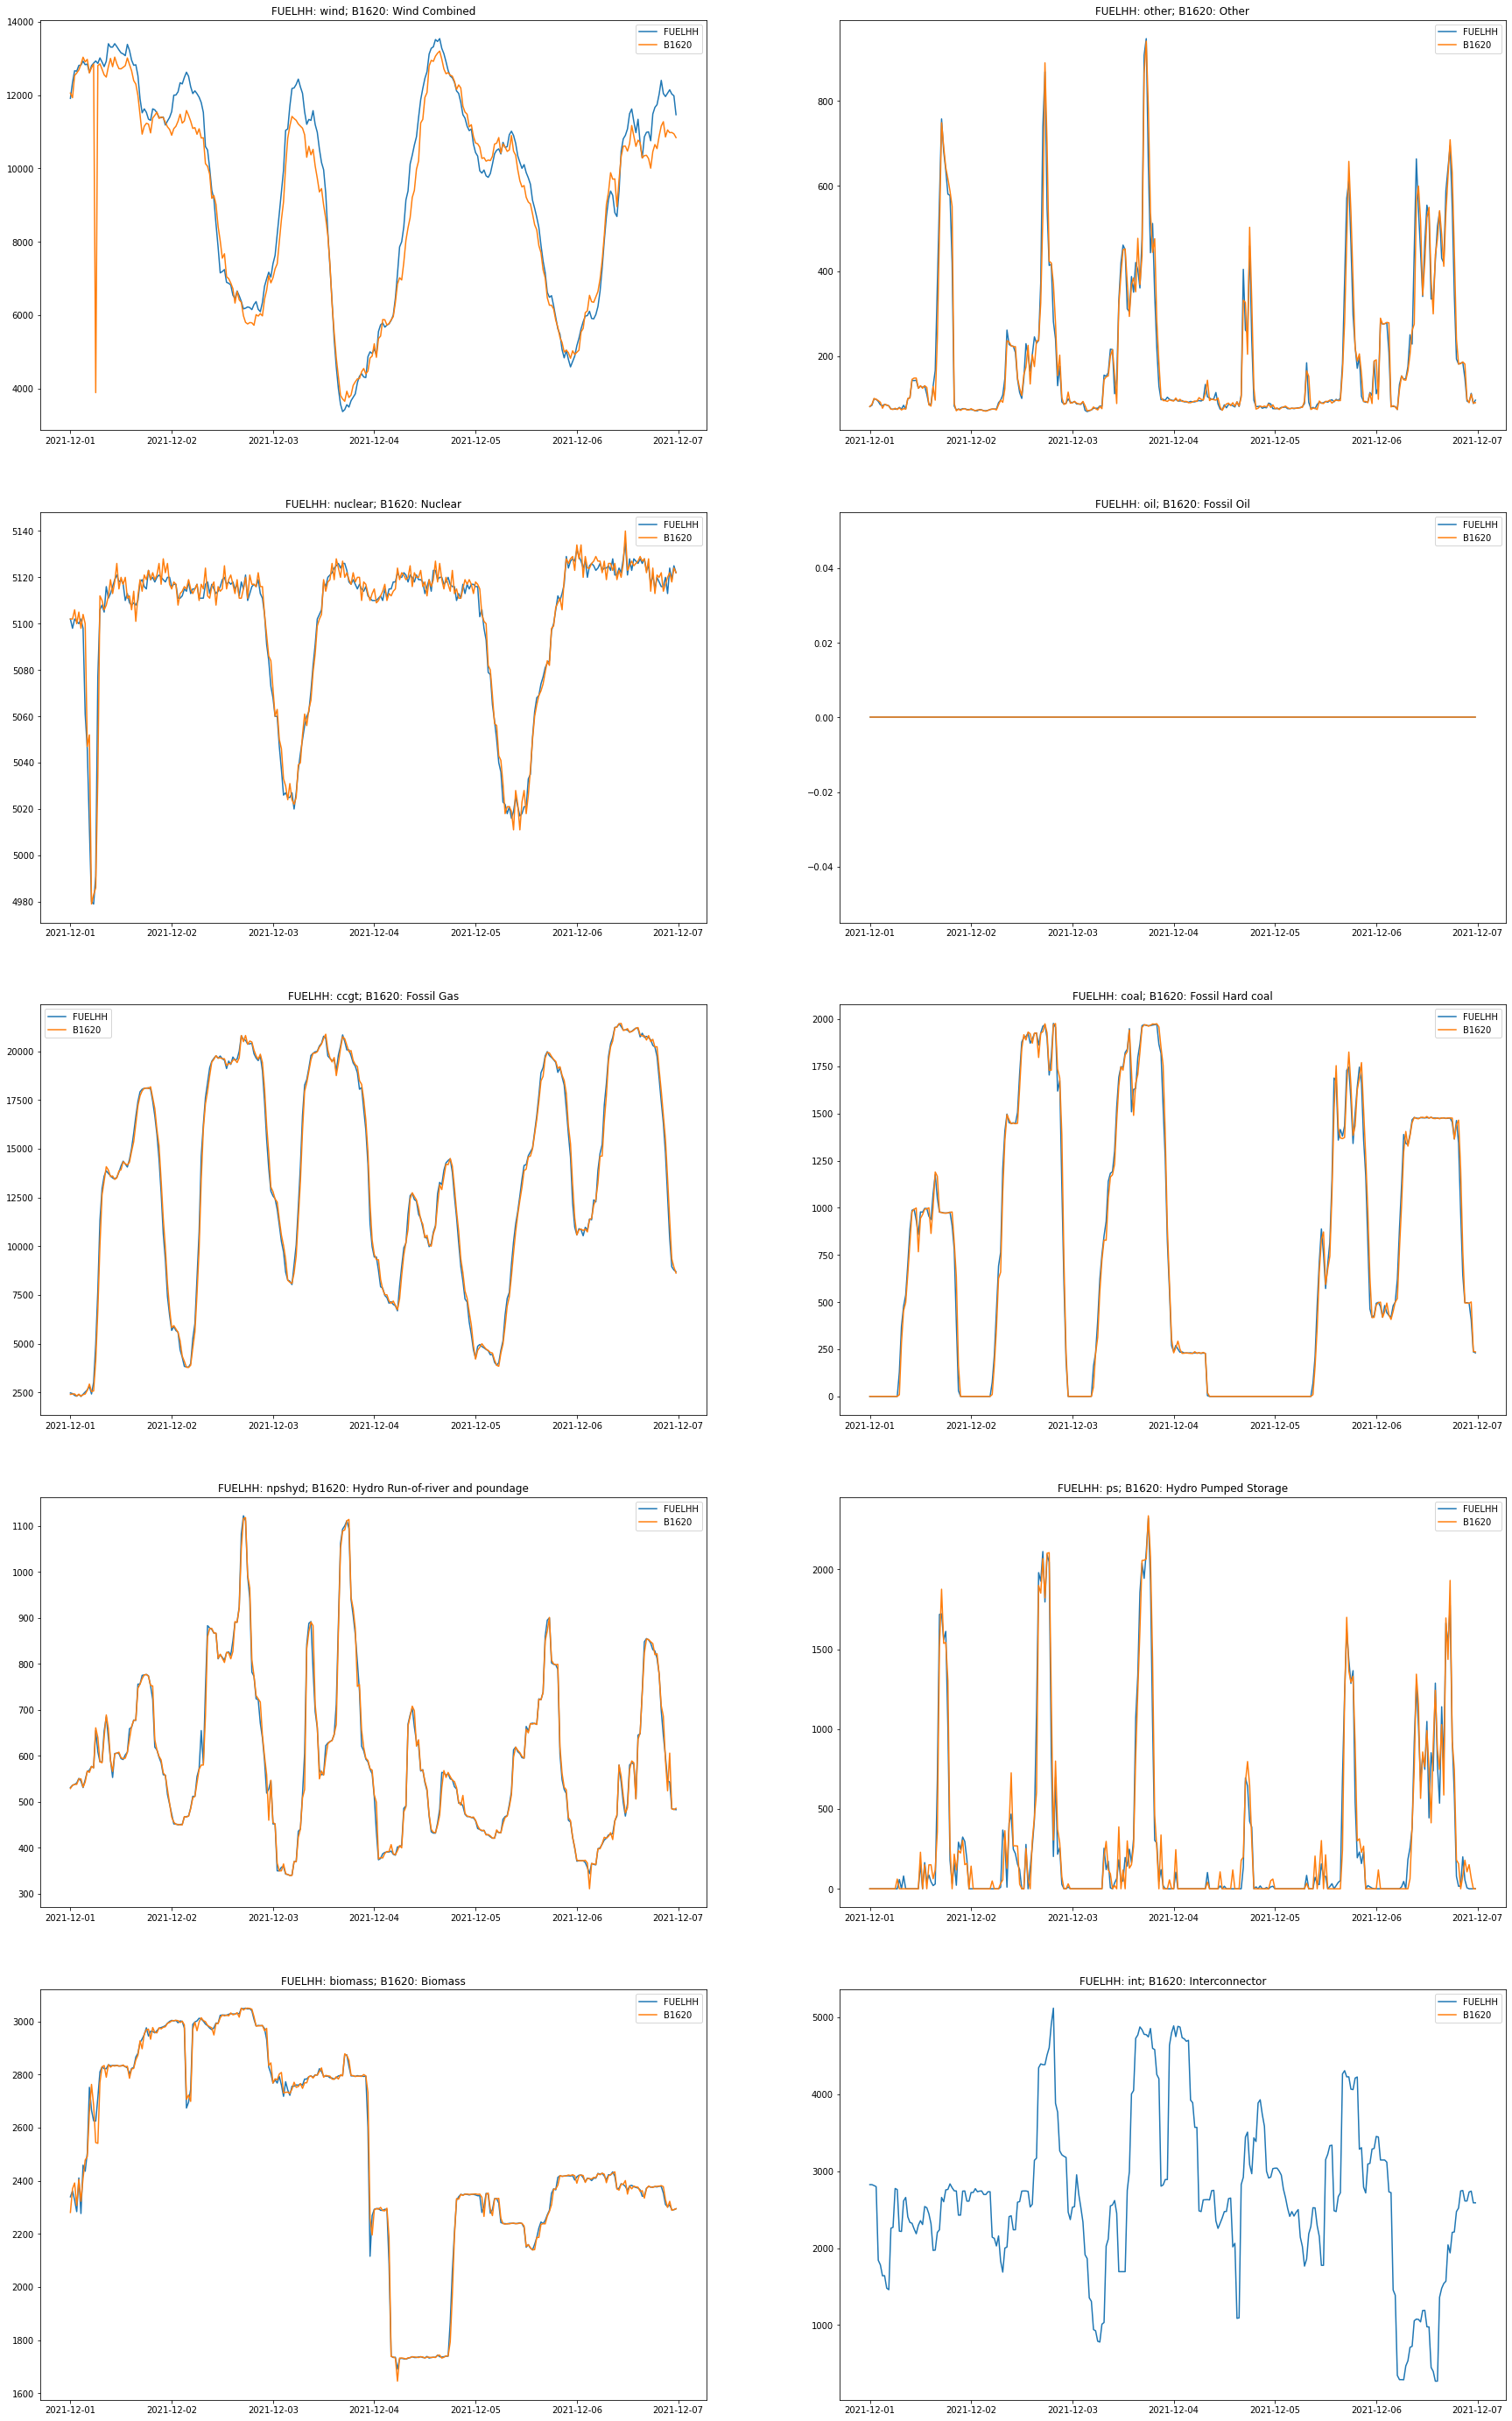

In [30]:
fig, ax = plt.subplots(5, 2, figsize=(30,50))

for i, type_tuple  in enumerate(supply_type_lookup.items()):
    fuel_hh_type, B1620_type = type_tuple
    im_x, im_y = i // 2, i % 2
    ax[im_x, im_y].plot(df_FUELHH[fuel_hh_type], label='FUELHH')

    if fuel_hh_type == 'wind':
        combined_wind = df_B1620.loc[(df_B1620['powerSystemResourceType'] == 'Wind Onshore') | (df_B1620['powerSystemResourceType'] == 'Wind Offshore'), 'quantity'].groupby('local_datetime').sum()
        ax[im_x, im_y].plot(combined_wind, label='B1620')
    else:
        ax[im_x, im_y].plot(df_B1620.loc[df_B1620['powerSystemResourceType'] == B1620_type, 'quantity'], label='B1620')
    
    ax[im_x, im_y].set_title(f'FUELHH: {fuel_hh_type}; B1620: {B1620_type}')
    ax[im_x, im_y].legend()


## Actual Total Load per Bidding Zone - B0610

Extracting [Actual Total Load per Bidding Zone](https://www.bmreports.com/bmrs/?q=totalload/actualtotalload). Note that there is only one zone.

### Set date range

In [31]:
# start_date = '2020-01-01 00:00'
# end_date = '2020-12-31 23:30'

start_date = '2021-12-01 00:00'
end_date = '2021-12-07 00:00'

start_date_str = start_date[:10].replace('-','')
end_date_str = end_date[:10].replace('-','')

### Request/Load data

In [32]:
b0610_filename = f'B0610_{start_date_str}_{end_date_str}.csv'
b0610_filename

'B0610_20211201_20211207.csv'

In [33]:
if os.path.isfile(os.path.join('data', b0610_filename)):
    df_B0610 = pd.read_csv(os.path.join('data', b0610_filename), index_col=0, parse_dates=True)
else:
    if not os.path.isdir('data'):
        os.mkdir('data')

    df_B0610 = client.get_B0610(start_date, end_date)
    df_B0610.to_csv(os.path.join('data', b0610_filename))

In [34]:
df_B0610.head()

,local_datetime,documentType,businessType,processType,timeSeriesID,settlementDate,settlementPeriod,quantity,objectAggregation,curveType,resolution,unitOfMeasure,activeFlag,documentID,documentRevNum
0,2021-12-01 00:00:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378327,2021-12-01,1,27616,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396902,1
1,2021-12-01 00:30:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378328,2021-12-01,2,28091,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396903,1
2,2021-12-01 01:00:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378329,2021-12-01,3,27448,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396904,1
3,2021-12-01 01:30:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378330,2021-12-01,4,26813,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396905,1
4,2021-12-01 02:00:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378331,2021-12-01,5,25359,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396906,1


### Necessary Processing

In [35]:
def process_demand_data(df):
    df = df.copy()

    df["quantity"] = df["quantity"].astype(float)
    df["documentRevNum"] = df["documentRevNum"].astype(int)
    df["local_datetime"] = pd.to_datetime(df["local_datetime"])
    df.set_index('local_datetime', inplace=True)

    df = df.loc[df['documentRevNum'] == 1]

    df['periodSinceRef'] = df.index.to_series().apply(getPeriodSinceRef)
    df['periodOfDay'] = df.index.to_series().apply(getPeriodOfDay)

    return df

In [36]:
df_B0610 = process_demand_data(df_B0610)

TODO: Implement check which ensures that no other values are found in these columns.

In [37]:
df_B0610[["documentType", "businessType", "processType", "curveType", "resolution", "activeFlag", "documentRevNum"]].drop_duplicates()

,documentType,businessType,processType,curveType,resolution,activeFlag,documentRevNum
local_datetime,,,,,,,
2021-12-01 00:00:00+00:00,System total load,Consumption,Realised,Sequential fixed size block,PT30M,Y,1


In [38]:
df_B0610.head()

,documentType,businessType,processType,timeSeriesID,settlementDate,settlementPeriod,quantity,objectAggregation,curveType,resolution,unitOfMeasure,activeFlag,documentID,documentRevNum,periodSinceRef,periodOfDay
local_datetime,,,,,,,,,,,,,,,,
2021-12-01 00:00:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378327,2021-12-01,1,27616.0,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396902,1,384240,0
2021-12-01 00:30:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378328,2021-12-01,2,28091.0,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396903,1,384241,1
2021-12-01 01:00:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378329,2021-12-01,3,27448.0,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396904,1,384242,2
2021-12-01 01:30:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378330,2021-12-01,4,26813.0,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396905,1,384243,3
2021-12-01 02:00:00+00:00,System total load,Consumption,Realised,NGET-EMFIP-ATL-TS-06378331,2021-12-01,5,25359.0,Area,Sequential fixed size block,PT30M,Mega watt,Y,NGET-EMFIP-ATL-06396906,1,384244,4


### Visualisation

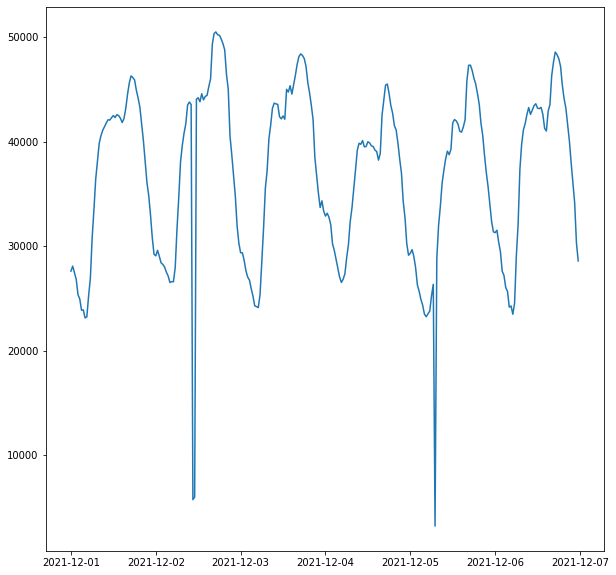

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(df_B0610['quantity'], label='Demand - B0610')

## Rolling System Demand

Extracting [Rolling System Demand](https://www.bmreports.com/bmrs/?q=demand/rollingsystemdemand). This is what Elexon use on their data dashboard. Two different versions of this are returned in the data:

- [TSDF - Transmission System Demand Forecast](https://www.bmreports.com/bmrs/?q=help/glossary#TSDF): The Transmission System Demand Forecast is made by the System Operator. The System Operator Transmission System Demand Forecast is based on historically metered generation output for Great Britain. This value INCLUDES Interconnector flows and demand from station transformers and pumped storage units. The Transmission System Demand Forecast is comparable with the Initial Transmission System Demand Out-Turn ITSDO). All the forecasts are unrestricted, i.e. any notified customer demand management is included in the history.
<br/><br/>
- [ITSDO - Initial Transmission System Demand Out-Turn](https://www.bmreports.com/bmrs/?q=help/glossary#ITSDO): The Initial Transmission System Demand Out-Turn is the average megawatt value of demand for a Settlement Period INCLUDING transmission losses, station transformer load, pumped storage demand and interconnector demand. The ITSDO is made available by the System Operator within 15 minutes after a Settlement Period, based on their operational metering. The composition of the Initial Transmission System Demand Out-Turn matches that of the Transmission System Demand Forecast and so ITSDO and TSDF are comparable. This figure is derived by the System Operator for submission to the BMRS but is not formally defined in the Grid Code.

And so, TSDF are the forecast values and ITSDO the actuals.

### Set date range

In [40]:
# start_date = '2020-01-01 00:00'
# end_date = '2020-12-31 23:30'

start_date = '2021-12-01 00:00'
end_date = '2021-12-07 00:00'

start_date_str = start_date[:10].replace('-','')
end_date_str = end_date[:10].replace('-','')

### Request/Load data

In [41]:
SYSDEM_filename = f'SYSDEM_{start_date_str}_{end_date_str}.csv'
SYSDEM_filename

'SYSDEM_20211201_20211207.csv'

In [42]:
if os.path.isfile(os.path.join('data', SYSDEM_filename)):
    df_SYSDEM = pd.read_csv(os.path.join('data', SYSDEM_filename), index_col=0, parse_dates=True)
else:
    if not os.path.isdir('data'):
        os.mkdir('data')

    df_SYSDEM = client.get_SYSDEM(start_date, end_date)
    df_SYSDEM.to_csv(os.path.join('data', SYSDEM_filename))

In [43]:
df_SYSDEM.head()

,local_datetime,recordType,startTimeOfHalfHrPeriod,settlementPeriod,demand,activeFlag
0,2021-12-01 00:00:00+00:00,TSDF,2021-12-01,1,26372.0,Y
1,2021-12-01 00:00:00+00:00,ITSDO,2021-12-01,1,25167.0,Y
2,2021-12-01 00:30:00+00:00,TSDF,2021-12-01,2,26672.0,Y
3,2021-12-01 00:30:00+00:00,ITSDO,2021-12-01,2,25578.0,Y
4,2021-12-01 01:00:00+00:00,TSDF,2021-12-01,3,26588.0,Y


### Necessary Processing

In [44]:
def process_sysdem_data(df):
    df = df.copy()

    df["demand"] = df["demand"].astype(float)
    df["local_datetime"] = pd.to_datetime(df["local_datetime"])
    df.set_index('local_datetime', inplace=True)

    df['periodSinceRef'] = df.index.to_series().apply(getPeriodSinceRef)
    df['periodOfDay'] = df.index.to_series().apply(getPeriodOfDay)

    return df

In [45]:
df_SYSDEM = process_sysdem_data(df_SYSDEM)

In [46]:
df_SYSDEM.head(6)

,recordType,startTimeOfHalfHrPeriod,settlementPeriod,demand,activeFlag,periodSinceRef,periodOfDay
local_datetime,,,,,,,
2021-12-01 00:00:00+00:00,TSDF,2021-12-01,1,26372.0,Y,384240,0
2021-12-01 00:00:00+00:00,ITSDO,2021-12-01,1,25167.0,Y,384240,0
2021-12-01 00:30:00+00:00,TSDF,2021-12-01,2,26672.0,Y,384241,1
2021-12-01 00:30:00+00:00,ITSDO,2021-12-01,2,25578.0,Y,384241,1
2021-12-01 01:00:00+00:00,TSDF,2021-12-01,3,26588.0,Y,384242,2
2021-12-01 01:00:00+00:00,ITSDO,2021-12-01,3,25864.0,Y,384242,2


### Visualisation

Plot SYSDEM and B0610. Hope is that these would be very similar.

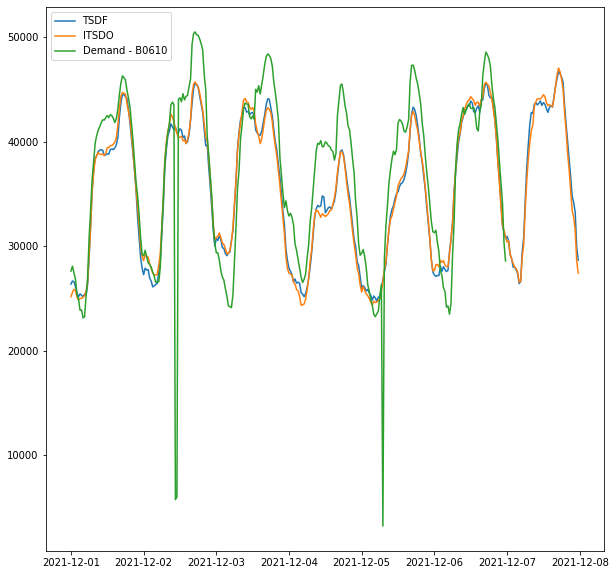

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(df_SYSDEM.loc[df_SYSDEM['recordType'] == 'TSDF', 'demand'], label='TSDF')
ax.plot(df_SYSDEM.loc[df_SYSDEM['recordType'] == 'ITSDO', 'demand'], label='ITSDO')
ax.plot(df_B0610['quantity'], label='Demand - B0610')
ax.legend()

Above plot shows that the forecasted and actual SYSDEM are similar, but that B0610 can be quite different.

Plot supply and demand data.

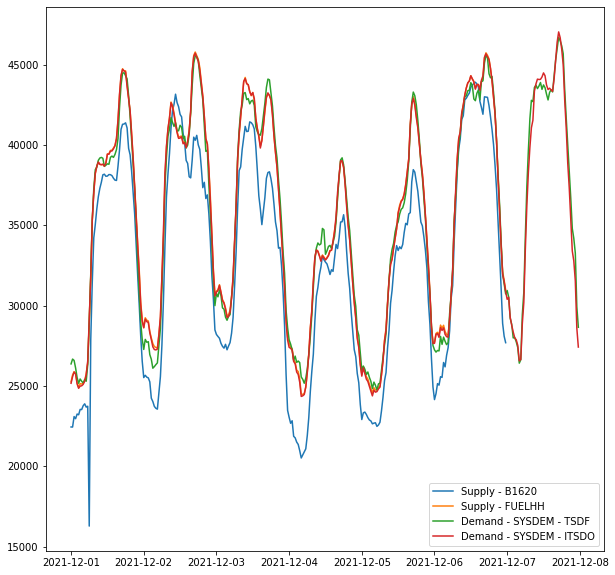

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(df_B1620.groupby(df_B1620.index)['quantity'].sum(), label='Supply - B1620')
ax.plot(df_FUELHH['total'], label='Supply - FUELHH')
ax.plot(df_SYSDEM.loc[df_SYSDEM['recordType'] == 'TSDF', 'demand'], label='Demand - SYSDEM - TSDF')
ax.plot(df_SYSDEM.loc[df_SYSDEM['recordType'] == 'ITSDO', 'demand'], label='Demand - SYSDEM - ITSDO')
ax.legend()

The above shows that the ITSDO system demand and the FUELHH supply match. This is expected, given how Elexon describe demand is calculated (see the info buttons on their dashboard).

In [49]:
SYSDEM_for_act = df_SYSDEM[['recordType', 'demand']].groupby('local_datetime').apply(lambda x: x.loc[x['recordType'] == 'TSDF', 'demand'] - x.loc[x['recordType'] == 'ITSDO', 'demand']).droplevel(1)
SYSDEM_for_act[:10]

local_datetime
2021-12-01 00:00:00+00:00    1205.0
2021-12-01 00:30:00+00:00    1094.0
2021-12-01 01:00:00+00:00     724.0
2021-12-01 01:30:00+00:00     377.0
2021-12-01 02:00:00+00:00     396.0
2021-12-01 02:30:00+00:00     312.0
2021-12-01 03:00:00+00:00     443.0
2021-12-01 03:30:00+00:00     284.0
2021-12-01 04:00:00+00:00      92.0
2021-12-01 04:30:00+00:00     105.0
Name: demand, dtype: float64

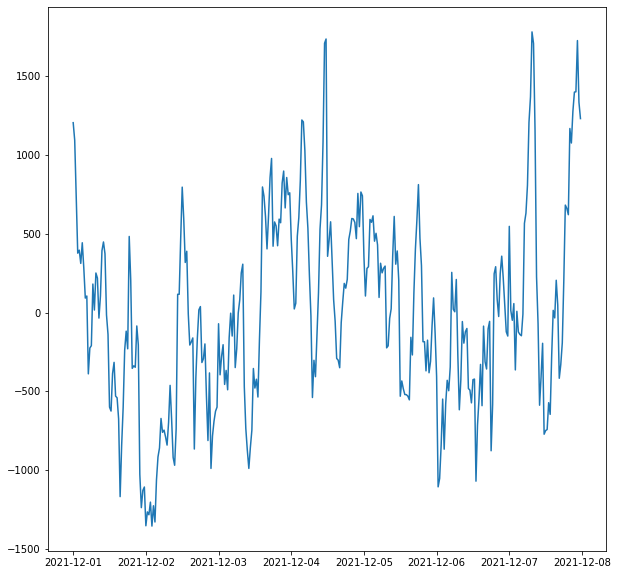

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(SYSDEM_for_act)

## Aggregated Imbalance Volumes - B1780

Extracting [Aggregated Imbalance Volumes](https://www.bmreports.com/bmrs/?q=balancing/aggregatedimbalance).

### Set date range

In [51]:
# start_date = '2020-01-01 00:00'
# end_date = '2020-12-31 23:30'

start_date = '2021-12-01 00:00'
end_date = '2021-12-07 00:00'

start_date_str = start_date[:10].replace('-','')
end_date_str = end_date[:10].replace('-','')

### Request/Load data

In [52]:
b1780_filename = f'B1780_{start_date_str}_{end_date_str}.csv'
b1780_filename

'B1780_20211201_20211207.csv'

In [53]:
if os.path.isfile(os.path.join('data', b1780_filename)):
    df_B1780 = pd.read_csv(os.path.join('data', b1780_filename), index_col=0, parse_dates=True)
else:
    if not os.path.isdir('data'):
        os.mkdir('data')

    df_B1780 = client.get_B1780(start_date, end_date)
    df_B1780.to_csv(os.path.join('data', b1780_filename))

In [54]:
df_B1780.head(10)

,local_datetime,timeSeriesId,businessType,controlArea,settlementDate,settlementPeriod,imbalanceQuantityMAW,curveType,resolution,documentType,processType,activeFlag,docStatus,documentID,documentRevNum,imbalanceQuantityDirection
0,2021-12-01 00:00:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,1,231.7522,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28018697,1,SURPLUS
1,2021-12-01 00:30:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,2,508.9161,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28018818,1,SURPLUS
2,2021-12-01 01:00:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,3,393.7500,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28018939,1,SURPLUS
3,2021-12-01 01:30:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,4,260.1398,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019060,1,SURPLUS
4,2021-12-01 02:00:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,5,-235.5398,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019180,1,DEFICIT
5,2021-12-01 02:30:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,6,-395.3067,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019322,1,DEFICIT
6,2021-12-01 03:00:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,7,-592.9600,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019454,1,DEFICIT
7,2021-12-01 03:30:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,8,-550.0030,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019594,1,DEFICIT
8,2021-12-01 04:00:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,9,-174.5339,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019821,1,DEFICIT
9,2021-12-01 04:30:00+00:00,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,2021-12-01,10,-45.2416,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,ELX-EMFIP-AIMBV-28019989,1,DEFICIT


In [55]:
df_B1780[['timeSeriesId', 'businessType', 'controlArea', 'curveType', 'resolution', 'documentType', 'processType', 'activeFlag', 'docStatus', 'documentRevNum', 'imbalanceQuantityDirection']].drop_duplicates()

,timeSeriesId,businessType,controlArea,curveType,resolution,documentType,processType,activeFlag,docStatus,documentRevNum,imbalanceQuantityDirection
0,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,1,SURPLUS
4,ELX-EMFIP-AIMBV-TS-1,Balance energy deviation,10YGB----------A,Sequential fixed size block,PT30M,Imbalance volume,Realised,Y,Final,1,DEFICIT


### Necessary Processing

In [56]:
def process_imbalance_data(df):
    df = df.copy()

    df["imbalanceQuantityMAW"] = df["imbalanceQuantityMAW"].astype(float)
    df["documentRevNum"] = df["documentRevNum"].astype(int)
    
    df["local_datetime"] = pd.to_datetime(df["local_datetime"])
    df.set_index('local_datetime', inplace=True)

    df = df.loc[df['documentRevNum'] == 1]
    df = df.loc[df['docStatus'] == 'Final']

    df['periodSinceRef'] = df.index.to_series().apply(getPeriodSinceRef)
    df['periodOfDay'] = df.index.to_series().apply(getPeriodOfDay)

    return df

In [57]:
df_B1780 = process_imbalance_data(df_B1780)

### Visualisation

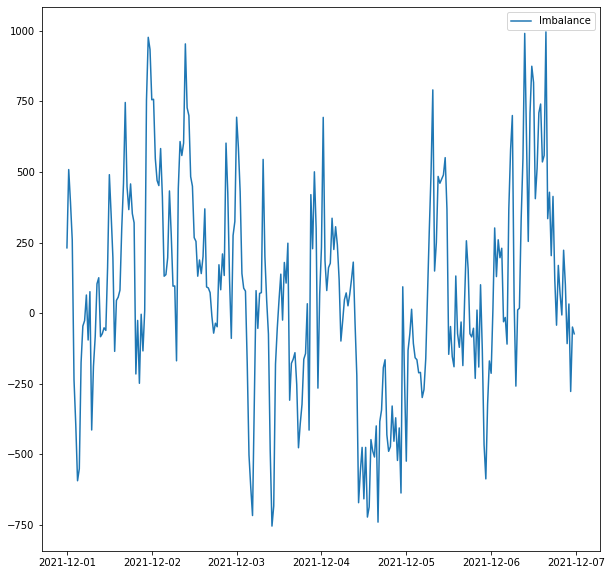

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(df_B1780['imbalanceQuantityMAW'], label='Imbalance')
# ax.plot(SYSDEM_for_act, label='Demand Forecast Shortfall')
ax.legend()

## Visualisations

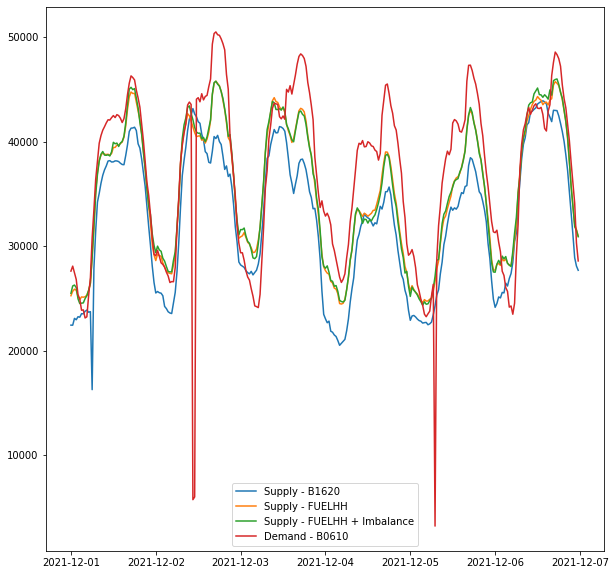

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(df_B1620.groupby(df_B1620.index)['quantity'].sum(), label='Supply - B1620')
ax.plot(df_FUELHH['total'], label='Supply - FUELHH')
ax.plot(df_FUELHH['total'] + df_B1780['imbalanceQuantityMAW'], label='Supply - FUELHH + Imbalance')
ax.plot(df_B0610['quantity'], label='Demand - B0610')
ax.legend()

# Modelling

## Mean Across the Day

Take the mean for each period in the day.

### B1620

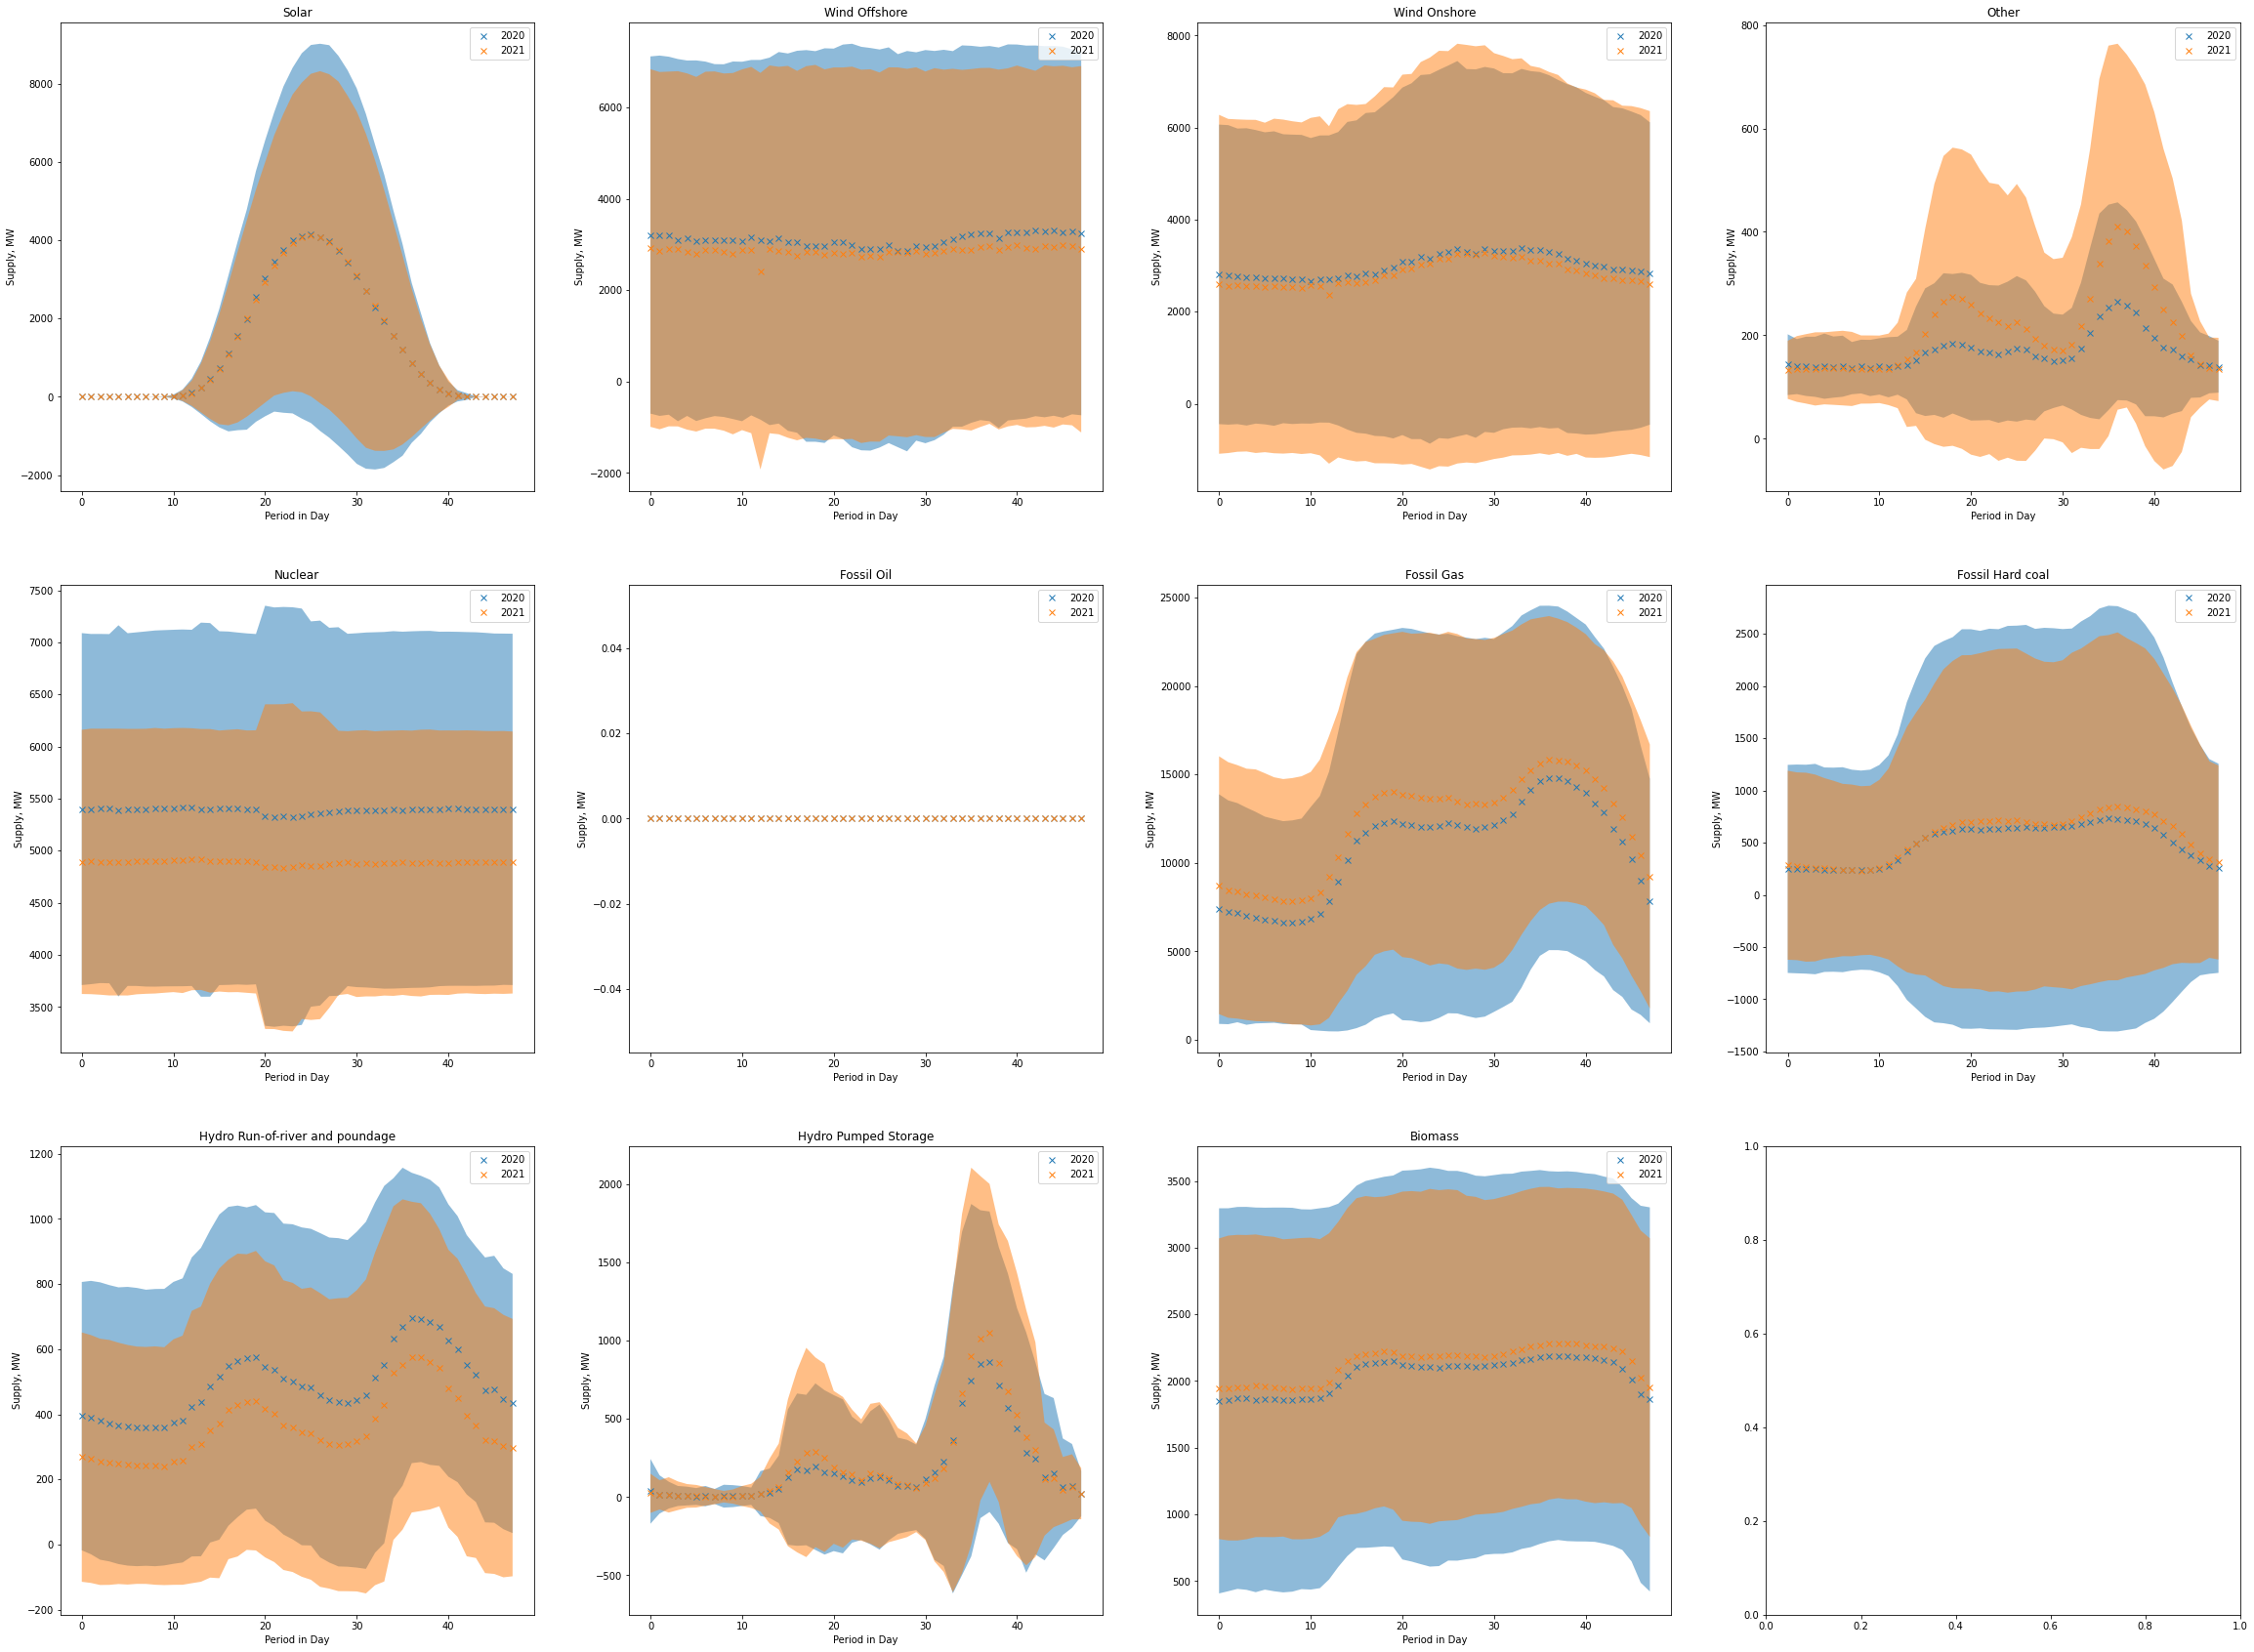

In [60]:
fig, ax = plt.subplots(3, 4, figsize=(40,30))

supply_dates = [
    ('20200101', '20201231'),
    ('20210101', '20211207')
]

for dates in supply_dates:
    start_date_str, end_date_str = dates
    b1620_filename = f'B1620_{start_date_str}_{end_date_str}.csv'
    df_B1620 = pd.read_csv(os.path.join('data', b1620_filename), index_col=0, parse_dates=True)
    df_B1620 = process_supply_data(df_B1620)
    for i, supply_type in enumerate(supply_types):
        im_x, im_y = i // 4, i % 4

        supply_data = df_B1620.loc[df_B1620["powerSystemResourceType"] == supply_type, ['quantity', 'periodSinceRef', 'periodOfDay']]

        # x = supply_data['periodSinceRef'].values[:,None]
        # y = supply_data['quantity'].values[:,None]

        x = supply_data['periodOfDay'].unique()[:,None]
        y = supply_data.groupby('periodOfDay').mean()['quantity'].values[:,None]
        y_std = supply_data.groupby('periodOfDay').std()['quantity'].values

        # ax.plot(supply_data.index, y)
        ax[im_x, im_y].plot(x, y, label=start_date_str[:4], marker='x', ls='')
        ax[im_x, im_y].fill_between(x.flatten(), y.flatten()-2*y_std, y.flatten()+2*y_std, alpha=0.5)

        ax[im_x, im_y].set_title(supply_type)
        ax[im_x, im_y].set_xlabel('Period in Day')
        ax[im_x, im_y].set_ylabel('Supply, MW')
        # ax[im_x, im_y].set_ylim(0, 25000)

        ax[im_x, im_y].legend()

### FUELHH

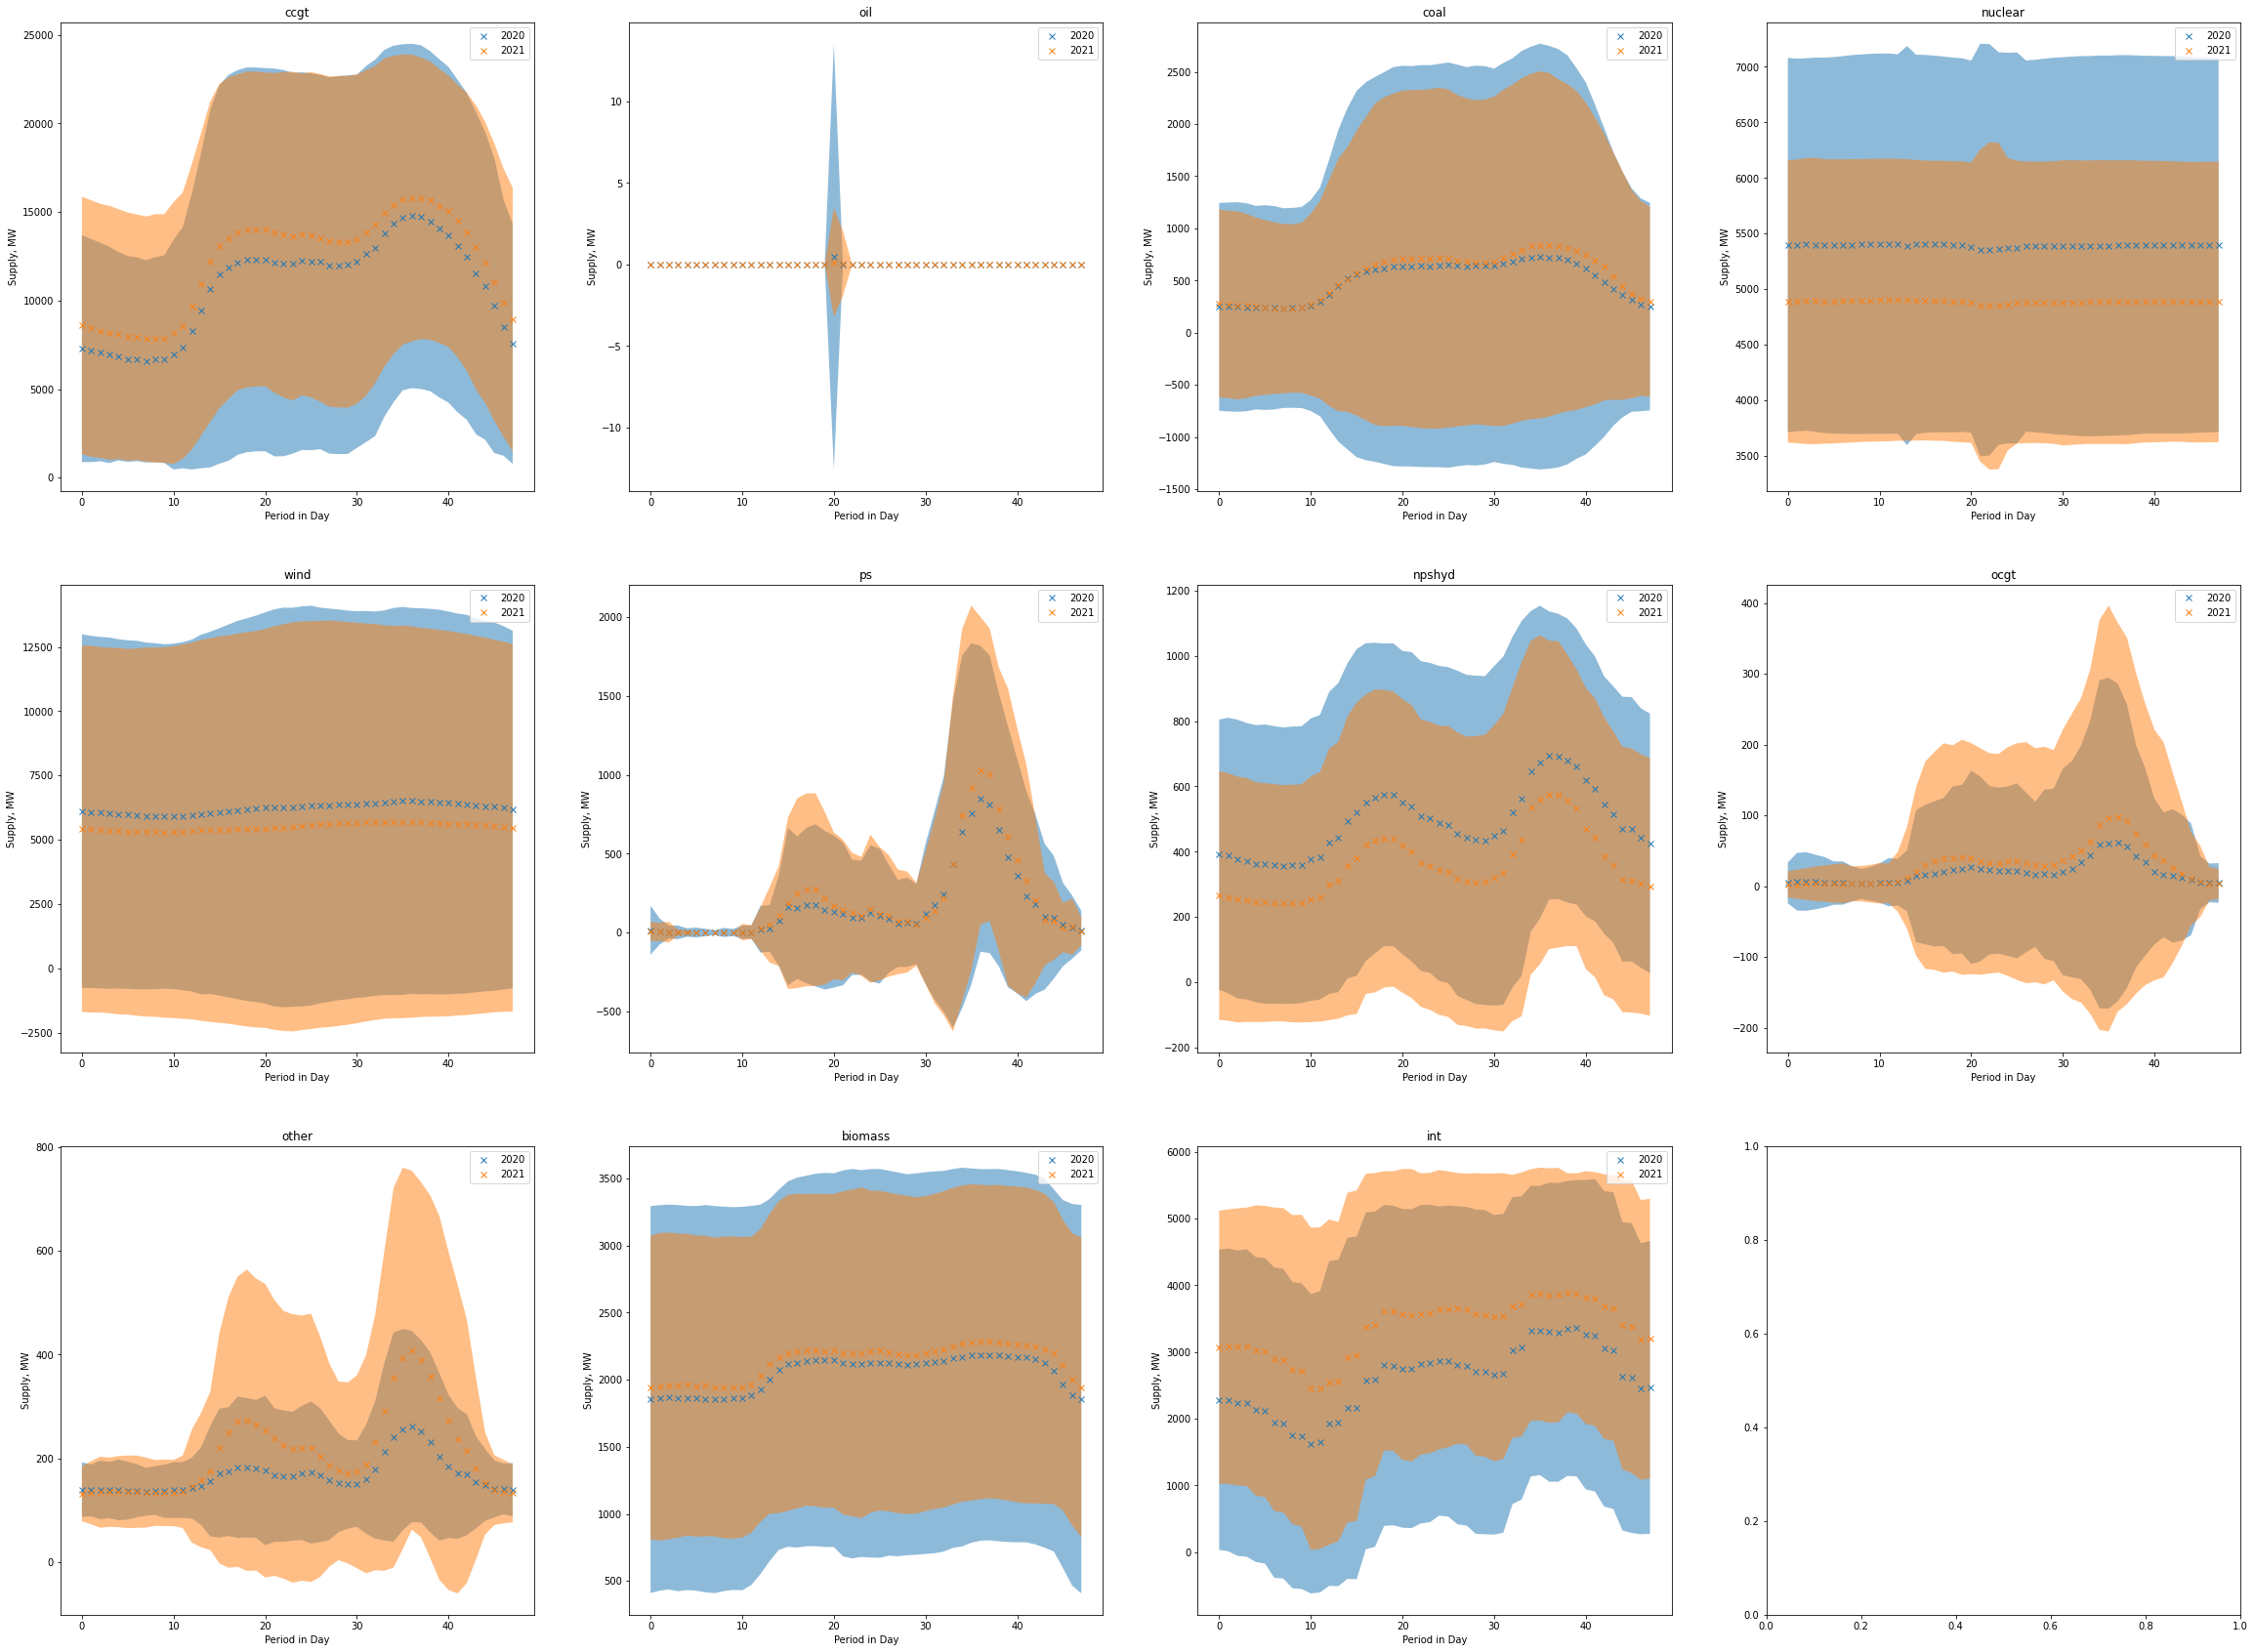

In [61]:
fig, ax = plt.subplots(3, 4, figsize=(40,30))

supply_dates = [
    ('20200101', '20201231'),
    ('20210101', '20211206')
]

for dates in supply_dates:
    start_date_str, end_date_str = dates
    FUELHH_filename = f'FUELHH_{start_date_str}_{end_date_str}.csv'
    df_FUELHH = pd.read_csv(os.path.join('data', FUELHH_filename), index_col=0, parse_dates=True)
    df_FUELHH = process_fuelhh_data(df_FUELHH)
    for i, supply_type in enumerate(FUELHH_supply_types):
        im_x, im_y = i // 4, i % 4

        supply_data = df_FUELHH[[supply_type, 'periodSinceRef', 'periodOfDay']].copy()
        supply_data['quantity'] = supply_data[supply_type]

        x = supply_data['periodOfDay'].unique()[:,None]
        y = supply_data.groupby('periodOfDay').mean()['quantity'].values[:,None]
        y_std = supply_data.groupby('periodOfDay').std()['quantity'].values

        ax[im_x, im_y].plot(x, y, label=start_date_str[:4], marker='x', ls='')
        ax[im_x, im_y].fill_between(x.flatten(), y.flatten()-2*y_std, y.flatten()+2*y_std, alpha=0.5)

        ax[im_x, im_y].set_title(supply_type)
        ax[im_x, im_y].set_xlabel('Period in Day')
        ax[im_x, im_y].set_ylabel('Supply, MW')

        ax[im_x, im_y].legend()

fig.savefig('supply.jpeg', pad_inches=0.2, bbox_inches='tight')

## GP Models

In [62]:
import GPy

### Set Dates

In [80]:
start_date = '2020-01-01 00:00'
end_date = '2020-12-31 23:30'

# start_date = '2021-01-01 00:00'
# end_date = '2021-12-07 23:30'

start_date_str = start_date[:10].replace('-','')
end_date_str = end_date[:10].replace('-','')

### Supply Models

#### B1620

In [81]:
# b1620_filename = f'B1620_{start_date_str}_{end_date_str}.csv'

# df_B1620 = pd.read_csv(os.path.join('data', b1620_filename), index_col=0, parse_dates=True)
# df_B1620 = process_supply_data(df_B1620)

# supply_type = 'Fossil Gas'
# supply_data = df_B1620.loc[df_B1620["powerSystemResourceType"] == supply_type, ['quantity', 'periodSinceRef', 'periodOfDay']]

#### FUELHH

In [82]:
FUELHH_filename = f'FUELHH_{start_date_str}_{end_date_str}.csv'

df_FUELHH = pd.read_csv(os.path.join('data', FUELHH_filename), index_col=0, parse_dates=True)
df_FUELHH = process_fuelhh_data(df_FUELHH)

supply_type = 'ccgt'
supply_data = df_FUELHH[[supply_type, 'periodSinceRef', 'periodOfDay']].copy()
supply_data['quantity'] = supply_data[supply_type]

In [83]:
x = supply_data['periodOfDay'].unique()[:,None]
y = supply_data.groupby('periodOfDay').mean()['quantity'].values[:,None]
y_std = supply_data.groupby('periodOfDay').std()['quantity'].values[:,None]

Set up model

In [84]:
## Single RBF kernel 
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

## Single periodic kernel
# kernel = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=48.0)

## Compound periodic kernel with linear trend
# kernel = (
#     # (GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.5)) +
#     (GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=1.0)) +
#     (GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=2.0))
#     # (GPy.kern.Linear(input_dim=1)) +
#     # (GPy.kern.White(input_dim=1, variance=0.1))
# )

In [95]:
np.random.seed(0)
m = GPy.models.GPRegression(x,y,kernel)
m.optimize_restarts(num_restarts=15, parallel=True, messages=False, robust=False, verbose=False)

## NOTE: Overriding the variance of the GP noise
m.Gaussian_noise.variance = (0.5*y_std.mean())**2
m.Gaussian_noise.variance.fix()

m

 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-pack

GP_regression.,value,constraints,priors
rbf.variance,51916449.98085179,+ve,
rbf.lengthscale,5.591065053544782,+ve,
Gaussian_noise.variance,5018189.180172738,+ve fixed,


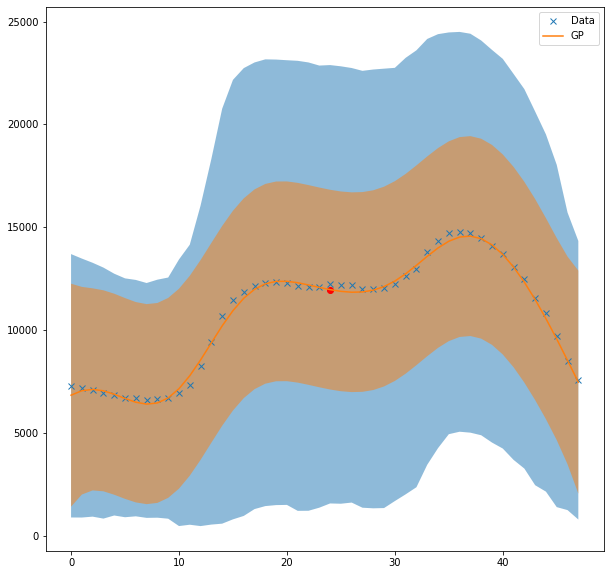

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mean, var = m.predict(x)
std = np.sqrt(var)

ax.plot(x, y, label='Data', marker='x', ls='')
ax.fill_between(x.flatten(), y.flatten()-2*y_std.flatten(), y.flatten()+2*y_std.flatten(), alpha=0.5)

ax.plot(x,mean, label='GP')
ax.fill_between(x.flatten(), (mean+2*std).flatten(), (mean-2*std).flatten(), alpha=0.5)

plt.scatter(24, m.predict(np.array([24])[:,None])[0][0], c='r')

ax.legend()

{'dataplot': [<matplotlib.collections.PathCollection at 0x134b0c0d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x1267ab040>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x1267985b0>]}

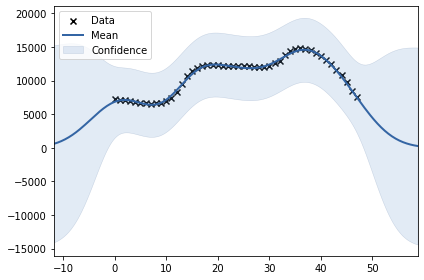

In [97]:
m.plot()

In [98]:
dict(zip(m.parameter_names_flat(), m.param_array))

{'GP_regression.rbf.variance': 51916449.98085179,
 'GP_regression.rbf.lengthscale': 5.591065053544782}

#### Fit all Generation Types

#### B1620

In [ ]:
# fig, ax = plt.subplots(3, 4, figsize=(40,30))

# supply_preds = np.zeros((len(x), len(supply_types)))

# for i, supply_type in enumerate(supply_types):
#     im_x, im_y = i // 4, i % 4

#     supply_data = df_B1620.loc[df_B1620["powerSystemResourceType"] == supply_type, ['quantity', 'periodSinceRef', 'periodOfDay']]

#     x = supply_data['periodOfDay'].unique()[:,None]
#     y = supply_data.groupby('periodOfDay').mean()['quantity'].values[:,None]
#     y_std = supply_data.groupby('periodOfDay').std()['quantity'].values

#     np.random.seed(0)
#     m = GPy.models.GPRegression(x,y,kernel)
#     m.optimize_restarts(num_restarts=15, parallel=True, messages=False, robust=False, verbose=False)
    
#     # NOTE: Overriding the variance of the GP noise
#     m.Gaussian_noise.variance = (0.5*y_std.mean())**2
#     m.Gaussian_noise.variance.fix()
    
#     m.pickle(os.path.join('models', f'supply_B1620_{supply_type.lower().replace(" ", "_")}.pkl'))

#     mean, var = m.predict(x)
#     std = np.sqrt(var)

#     supply_preds[:,i] = mean.flatten()

#     ax[im_x, im_y].plot(x, y, label='Data - Mean')
#     ax[im_x, im_y].fill_between(x.flatten(), y.flatten()-2*y_std, y.flatten()+2*y_std, alpha=0.5, label='Data - 2 Std Devs')

#     ax[im_x, im_y].plot(x,mean, label='GP - Mean')
#     ax[im_x, im_y].fill_between(x.flatten(), (mean+2*std).flatten(), (mean-2*std).flatten(), alpha=0.5, label='GP - 95 % CI')

#     ax[im_x, im_y].set_title(supply_type)
#     ax[im_x, im_y].set_xlabel('Period in Day')
#     ax[im_x, im_y].set_ylabel('Supply, MW')
#     # ax[im_x, im_y].set_ylim(0, 25000)

#     ax[im_x, im_y].legend()

# fig.savefig('daily_gp_fit.jpeg', pad_inches=0.2, bbox_inches='tight')

### FUELHH

In [112]:
supply_type_lookup

{'wind': 'Wind Combined',
 'other': 'Other',
 'nuclear': 'Nuclear',
 'oil': 'Fossil Oil',
 'ccgt': 'Fossil Gas',
 'coal': 'Fossil Hard coal',
 'npshyd': 'Hydro Run-of-river and poundage',
 'ps': 'Hydro Pumped Storage',
 'biomass': 'Biomass',
 'int': 'Interconnector'}

 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/si

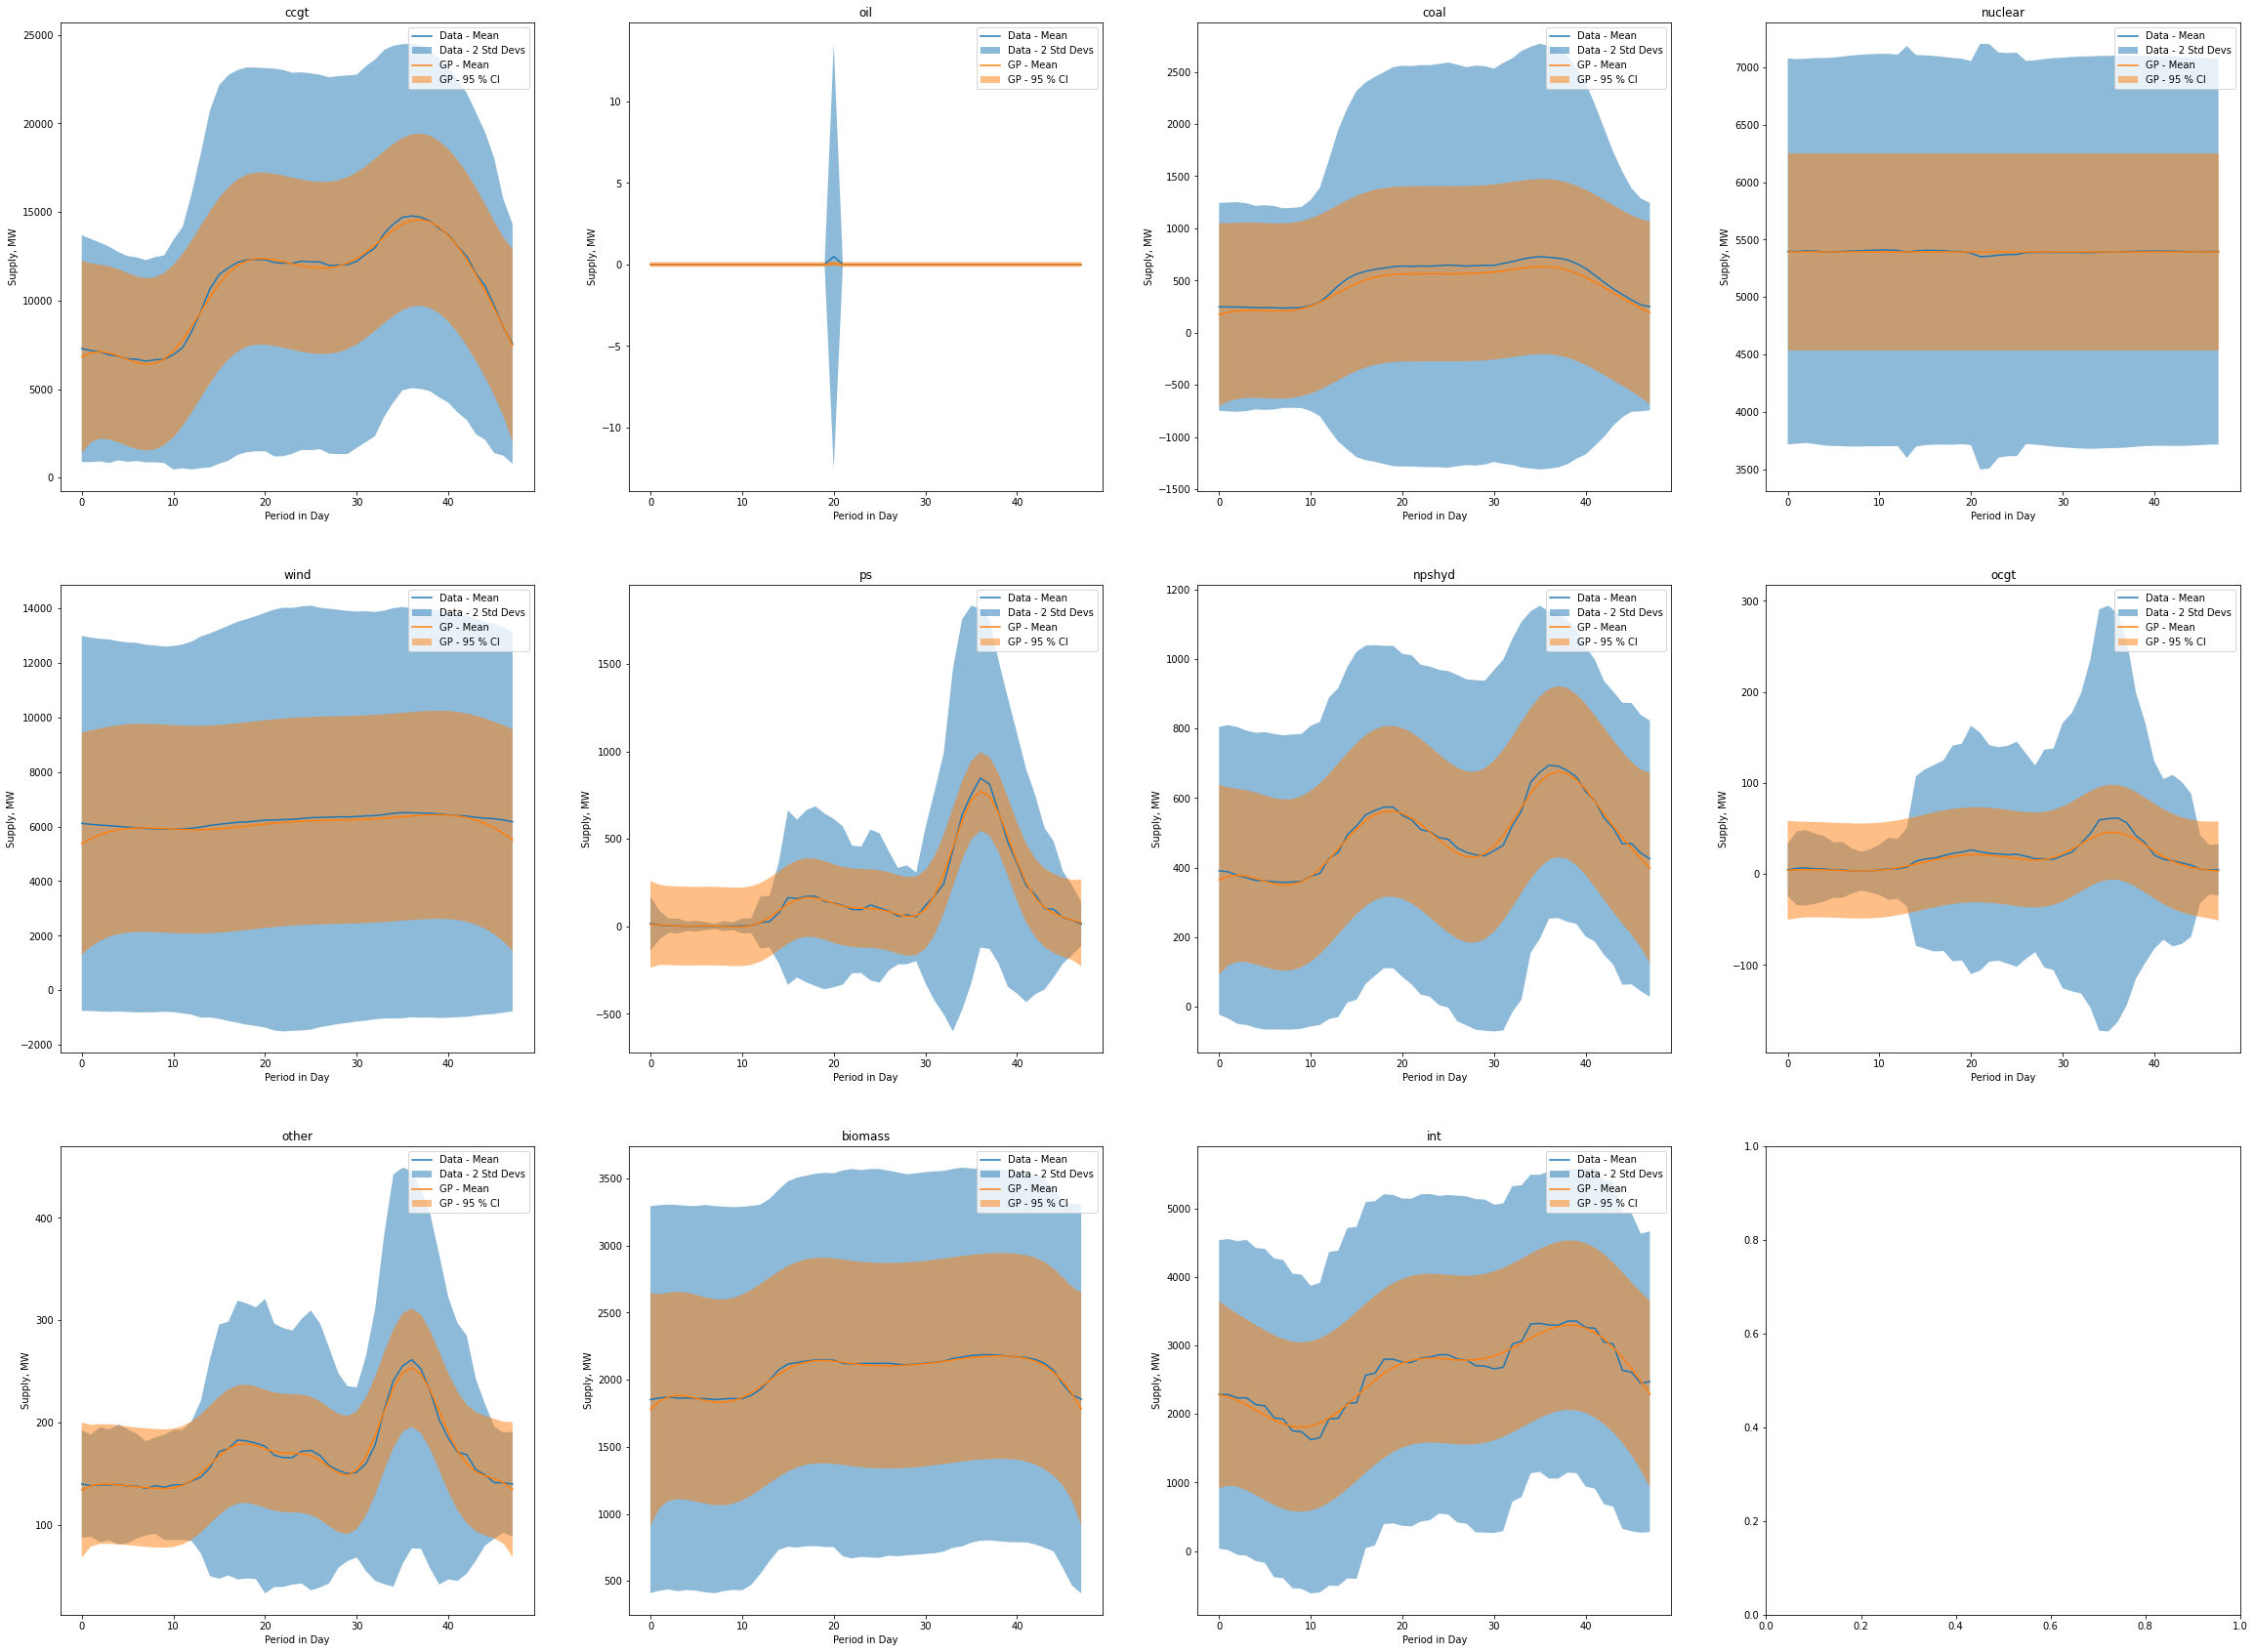

In [99]:
fig, ax = plt.subplots(3, 4, figsize=(40,30))

supply_preds = np.zeros((len(x), len(supply_types)))

for i, supply_type in enumerate(FUELHH_supply_types):
    im_x, im_y = i // 4, i % 4

    supply_data = df_FUELHH[[supply_type, 'periodSinceRef', 'periodOfDay']].copy()
    supply_data['quantity'] = supply_data[supply_type]

    x = supply_data['periodOfDay'].unique()[:,None]
    y = supply_data.groupby('periodOfDay').mean()['quantity'].values[:,None]
    y_std = supply_data.groupby('periodOfDay').std()['quantity'].values

    np.random.seed(0)
    m = GPy.models.GPRegression(x,y,kernel)
    m.optimize_restarts(num_restarts=15, parallel=True, messages=False, robust=False, verbose=False)

    ## NOTE: Overriding the variance of the GP noise
    m.Gaussian_noise.variance = (0.5*y_std.mean())**2
    m.Gaussian_noise.variance.fix()

    B1620_name = supply_type_lookup.get(supply_type, supply_type)
    m.pickle(os.path.join('models', f'supply_FUELHH_{B1620_name.lower().replace(" ", "_")}.pkl'))

    mean, var = m.predict(x)
    std = np.sqrt(var)

    supply_preds[:,i] = mean.flatten()

    ax[im_x, im_y].plot(x, y, label='Data - Mean')
    ax[im_x, im_y].fill_between(x.flatten(), y.flatten()-2*y_std, y.flatten()+2*y_std, alpha=0.5, label='Data - 2 Std Devs')

    ax[im_x, im_y].plot(x,mean, label='GP - Mean')
    ax[im_x, im_y].fill_between(x.flatten(), (mean+2*std).flatten(), (mean-2*std).flatten(), alpha=0.5, label='GP - 95 % CI')

    ax[im_x, im_y].set_title(supply_type)
    ax[im_x, im_y].set_xlabel('Period in Day')
    ax[im_x, im_y].set_ylabel('Supply, MW')
    # ax[im_x, im_y].set_ylim(0, 25000)

    ax[im_x, im_y].legend()

fig.savefig('daily_gp_fit.jpeg', pad_inches=0.2, bbox_inches='tight')

Text(0, 0.5, 'Supply, MW')

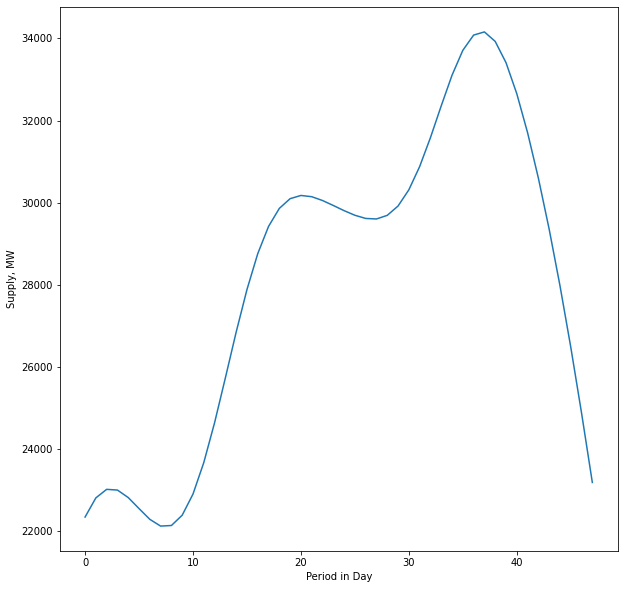

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(x, supply_preds.sum(axis=1))
ax.set_xlabel('Period in Day')
ax.set_ylabel('Supply, MW')

### Demand Model

#### B0610

In [101]:
# b0610_filename = f'B0610_{start_date_str}_{end_date_str}.csv'

# df_B0610 = pd.read_csv(os.path.join('data', b0610_filename), index_col=0, parse_dates=True)
# df_B0610 = process_demand_data(df_B0610)

# demand_data = df_B0610[['quantity', 'periodSinceRef', 'periodOfDay']]
# x = demand_data['periodOfDay'].unique()[:,None]
# y = demand_data.groupby('periodOfDay').mean()['quantity'].values[:,None]

#### FUELHH

In [104]:
FUELHH_filename = f'FUELHH_{start_date_str}_{end_date_str}.csv'

df_FUELHH = pd.read_csv(os.path.join('data', FUELHH_filename), index_col=0, parse_dates=True)
df_FUELHH = process_fuelhh_data(df_FUELHH)

demand_data = df_FUELHH[['total', 'periodSinceRef', 'periodOfDay']].copy()
demand_data['quantity'] = demand_data['total']
x = demand_data['periodOfDay'].unique()[:,None]
y = demand_data.groupby('periodOfDay').mean()['quantity'].values[:,None]
y_std = demand_data.groupby('periodOfDay').std()['quantity'].values[:,None]

Set up model

In [105]:
## Single RBF kernel 
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

## Single periodic kernel
# kernel = GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=48.0)

## Compound periodic kernel with linear trend
# kernel = (
#     # (GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=0.5)) +
#     (GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=1.0)) +
#     (GPy.kern.StdPeriodic(input_dim=1, variance=1.0, period=2.0))
#     # (GPy.kern.Linear(input_dim=1)) +
#     # (GPy.kern.White(input_dim=1, variance=0.1))
# )

In [106]:
np.random.seed(0)
m = GPy.models.GPRegression(x,y,kernel)
m.optimize_restarts(num_restarts=15, parallel=True, messages=False, robust=False, verbose=False)

## NOTE: Overriding the variance of the GP noise
m.Gaussian_noise.variance = (0.5*y_std.mean())**2
m.Gaussian_noise.variance.fix()

m

 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply
 /Users/alanclark/.pyenv/versions/3.8.11/envs/mlpw/lib/python3.8/s

GP_regression.,value,constraints,priors
rbf.variance,320590559.2295437,+ve,
rbf.lengthscale,5.871097904027234,+ve,
Gaussian_noise.variance,5762588.465780356,+ve fixed,


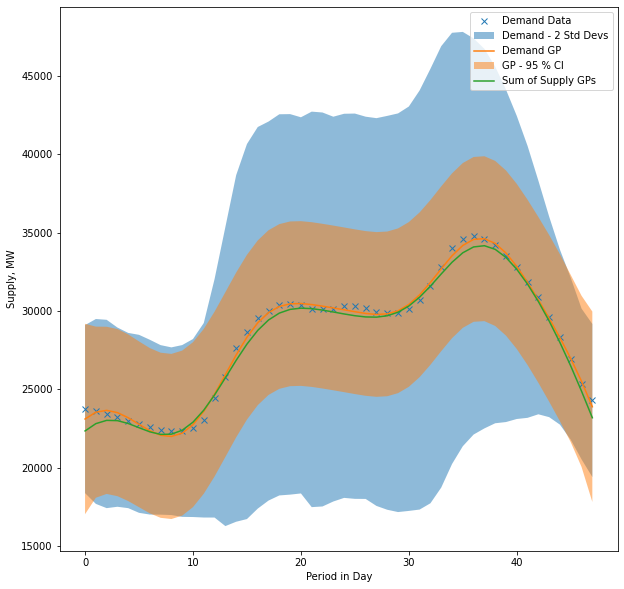

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
mean, var = m.predict(x)
std = np.sqrt(var)

ax.plot(x, y, label='Demand Data', marker='x', ls='')
ax.fill_between(x.flatten(), y.flatten()-2*y_std.flatten(), y.flatten()+2*y_std.flatten(), alpha=0.5, label='Demand - 2 Std Devs')

ax.plot(x,mean, label='Demand GP')
ax.fill_between(x.flatten(), (mean+2*std).flatten(), (mean-2*std).flatten(), alpha=0.5, label='GP - 95 % CI')

ax.plot(x, supply_preds.sum(axis=1), label='Sum of Supply GPs')

ax.set_xlabel('Period in Day')
ax.set_ylabel('Supply, MW')
ax.legend()

In [ ]:
m.plot()

In [ ]:
dict(zip(m.parameter_names_flat(), m.param_array))

In [ ]:
m.pickle(os.path.join('models', 'demand.pkl'))